# Airline Sentiment Analysis

## Table of Contents:
* [Data Collection](#DataCollection)
* [Data Wrangling](#DataWrangling)
* [EDA](#EDA)
    * [Airline Sentiment EDA](#airlineSentimentEDA)
    * [Airline EDA](#airlineEDA)
    * [Predictive Words](#pw)
    * [Predictive Words by Airline](#pwa)
    * [Date vs Airline Sentiment](#Date)
    * [User Timezone](#user_timezone)
* [Conclusion](#Conclusion) 

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#this will deal with punctuation
import string
#TOKENIZATTION
import re
#STOPWORDS
#from nltk.corpus import stopwords 
#import nltk
#LEMMATIZING
from nltk.stem import WordNetLemmatizer
from emoji import UNICODE_EMOJI
import emoji
from string import digits

import nltk #using the Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Data Collection <a class="anchor" id="DataCollection"></a>

In [2]:
#get data
tweets = pd.read_csv("../Data/Tweets.csv")

## Proportion of Uppercase Text in Tweet

In [3]:
def wordUpper(text):
    return sum(map(str.isupper, text)) / len(text)

tweets["uppercase"] = tweets["text"].apply(lambda x: wordUpper(x))

tweets.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   

   uppercase  
0   0.085714  
1   0.027778  
2   0.070423

## Check if text has emoji

In [4]:
#is_emoji("😘")

def checkEmoji(text):
    """for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
   
    return False"""
    has_emoji = bool(emoji.get_emoji_regexp().search(text))
    return has_emoji
    

tweets["emoji"] = tweets["text"].apply(lambda x: checkEmoji(x))

tweets.head(3)

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_83984/1737344709.py:9: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  has_emoji = bool(emoji.get_emoji_regexp().search(text))


tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                        0.0  Virgin America   
2            NaN                        NaN  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   

   uppercase  emoji  
0   0.085714  False  
1   0.027778  False  
2   0.070423  False

# 2. Data Wrangling <a class="anchor" id="DataWrangling"></a>

The following needs to be done to preprocess the data:

1. Make text lowercase
2. Removing punctuations, URLs, names
3. Tokenization
4. Removing stopwords ("this", "is", etc.)
4. Lemmatizing

In [5]:
#tweets[(tweets["negativereason"] == "Late Flight") & (tweets["airline"] == "United")]

In [6]:
#drop columns of >= 90% null values
tweets = tweets.drop(columns=["airline_sentiment_gold" , "negativereason_gold", "tweet_coord"])

In [7]:
#Lowercase
#tweets["text"] = tweets["text"].str.lower()
#tweets["text"] = tweets["text"].apply(lambda x: x.lower())
tweets["text"] =[x.lower() for x in tweets.text]
#texts = [[word.lower() for word in text.split()] for text in data]

#remove numbers
tweets["text"] = tweets["text"].str.replace('\d+', '', regex=True)

##REMOVE PUNCTUATIONS
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

tweets["text"] = tweets["text"].apply(lambda x: remove_punc(x))

In [8]:
#REMOVE WHITESPACE
tweets["text"] = tweets["text"].str.strip()

#remove emoji
tweets["text"] = tweets["text"].apply(lambda x: emoji.demojize(x))
tweets["text"].head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercials to ...
2    virginamerica i didnt today must mean i need t...
3    virginamerica its really aggressive to blast o...
4    virginamerica and its a really big bad thing a...
Name: text, dtype: object

In [9]:
#LEMMATIZING
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    word_list = nltk.word_tokenize(text)
    lem_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lem_text

tweets["text"] = tweets["text"].apply(lambda x: word_lemmatizer(x))
tweets.text.head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercial to t...
2    virginamerica i didnt today must mean i need t...
3    virginamerica it really aggressive to blast ob...
4    virginamerica and it a really big bad thing ab...
Name: text, dtype: object

In [10]:
#REMOVE STOPWORDS and tokenize
def remove_stopwords(text):
    tokens = word_tokenize(text)
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords = [t for t in tokens if t not in english_stopwords]
    
    return tokens_wo_stopwords

tweets["text"] = tweets["text"].apply(lambda x: remove_stopwords(str(x)))
tweets["text"].head()

0                      [virginamerica, dhepburn, said]
1    [virginamerica, plus, youve, added, commercial...
2    [virginamerica, didnt, today, must, mean, need...
3    [virginamerica, really, aggressive, blast, obn...
4             [virginamerica, really, big, bad, thing]
Name: text, dtype: object

# 3. EDA <a class="anchor" id="EDA"></a>

## View distribution of sentiment

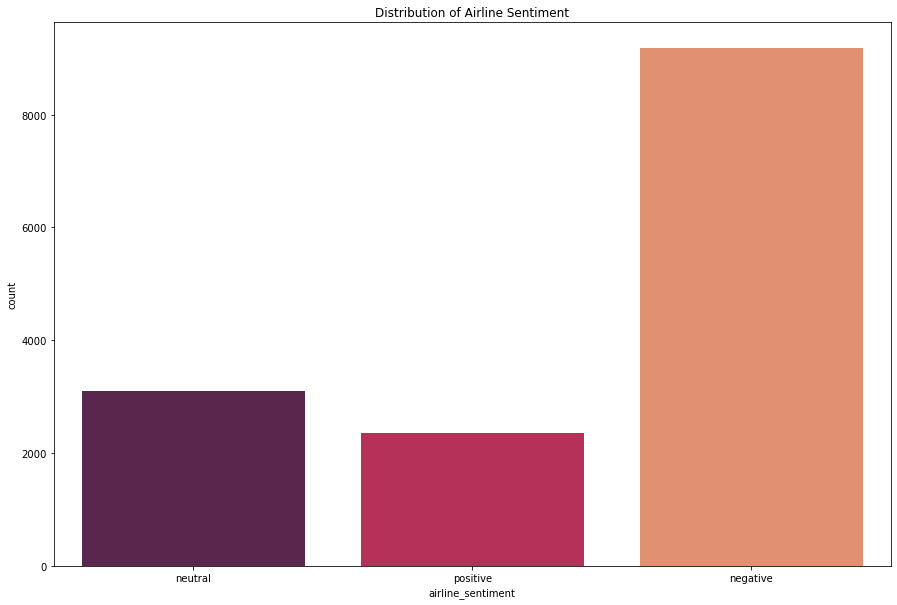

In [11]:
figure, ax = plt.subplots(figsize=(15,10))
ax = sns.countplot(x = tweets["airline_sentiment"], palette='rocket').set(title="Distribution of Airline Sentiment")

#### View the polarity of a tweet 

In [12]:
from textblob import TextBlob, Word, Blobber
tweets['polarity']=tweets['text'].map(lambda text: TextBlob(str(text)).sentiment.polarity)
tweets.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                     0.0000  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   
3     Bad Flight                     0.7033  Virgin America    jnardino   
4     Can't Tell                     1.0000  Virgin America    jnardino   

   retweet_count                                               text  \
0              0                    [virginamerica, dhepburn, said]   
1              0  [virginamerica, plus, youve, added, commercial...   
2              0  [virginamerica, didnt, today, must, mean, need...   
3              0  [virginamerica, really, aggressive, blast, obn...   
4              0           [virginamerica, really, big, bad, thing]   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   

   uppercase  emoji  polarity  
0   0.085714  False   0.00000  
1   0.027778  False   0.00000  
2   0.070423  False  -0.31250  
3   0.015873  False   0.00625  
4   0.036364  False  -0.35000

#### View the distribution of the polarity of the tweet

Text(0.5, 1.0, 'Distibution of polarity')

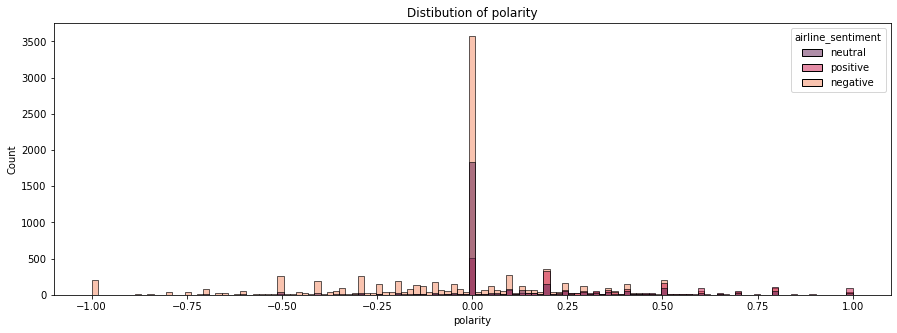

In [13]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.histplot(x = tweets["polarity"], palette="rocket", hue=tweets["airline_sentiment"])

plt.title("Distibution of polarity")

Let's look at the length of text

Text(0.5, 1.0, 'Distibution of text length')

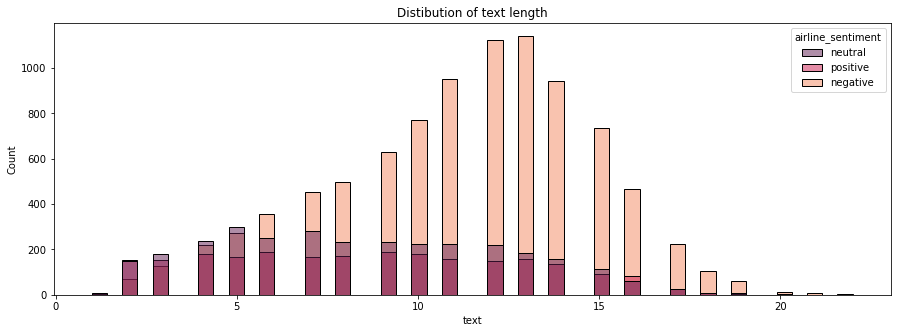

In [14]:
fig, axes = plt.subplots(figsize=(15, 5))
textLen = tweets["text"].apply(lambda x: len(x))
axes = sns.histplot(x = textLen, palette="rocket", hue=tweets["airline_sentiment"], bins=50)

plt.title("Distibution of text length")

## Uppercase of text

### Word count

In [15]:
# get a word count per sentence column
def wordCount(text):
    return len(text)

tweets["word_count"] = tweets["text"].apply(lambda x: wordCount(x))

tweets.head(3)

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   

  negativereason  negativereason_confidence         airline        name  \
0            NaN                        NaN  Virgin America     cairdin   
1            NaN                        0.0  Virgin America    jnardino   
2            NaN                        NaN  Virgin America  yvonnalynn   

   retweet_count                                               text  \
0              0                    [virginamerica, dhepburn, said]   
1              0  [virginamerica, plus, youve, added, commercial...   
2              0  [virginamerica, didnt, today, must, mean, need...   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   

   uppercase  emoji  polarity  word_count  
0   0.085714  False    0.0000           3  
1   0.027778  False    0.0000           7  
2   0.070423  False   -0.3125           9

### Let's visualize this

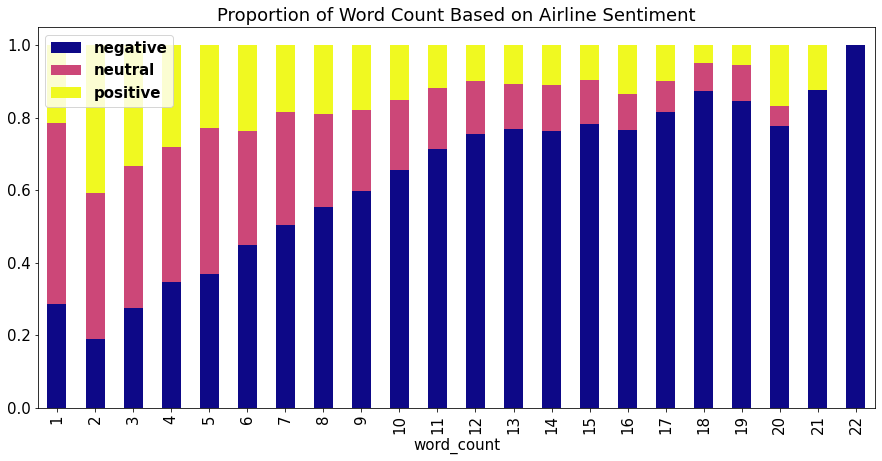

In [16]:
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 15})
plt.rc('legend', fontsize=15)

#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')


tweets.groupby('word_count')['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")
plt.title("Proportion of Word Count Based on Airline Sentiment")

plt.legend(loc="upper right")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

plt.show()

The negative sentiment has more words in the tweet

## Check the percentage of text that are uppercase

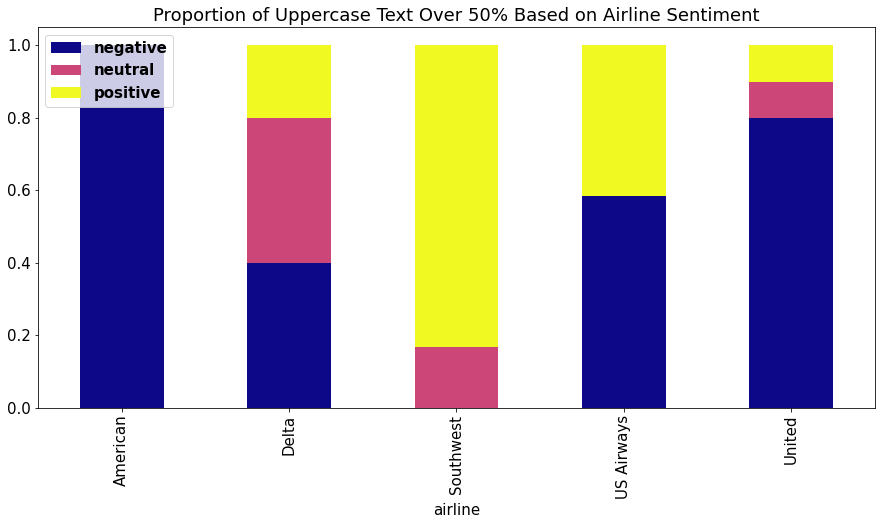

In [17]:
df = tweets[tweets["uppercase"] > 0.50]

df.groupby('airline')['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")
plt.title("Proportion of Uppercase Text Over 50% Based on Airline Sentiment")

plt.legend(loc="upper right")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

plt.show()

## Check the proportion of tweets with an emoji in text

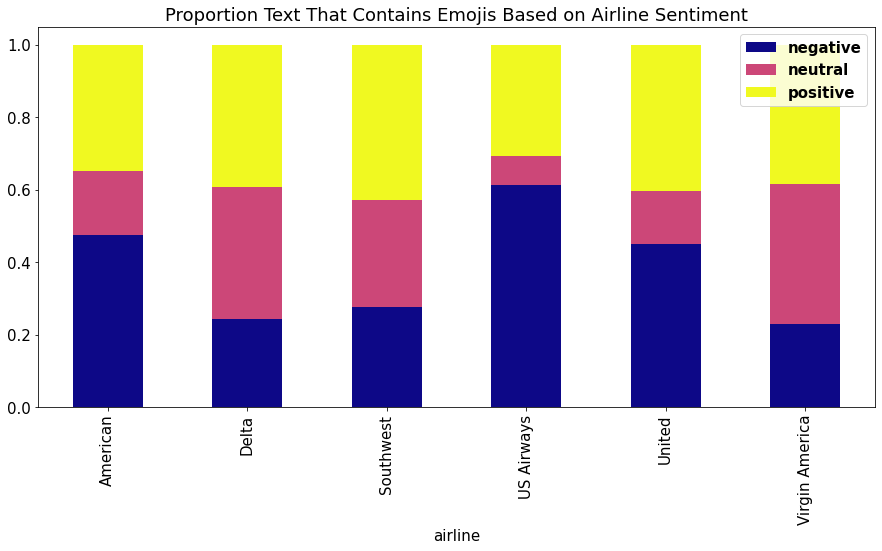

In [18]:
df = tweets[tweets["emoji"] == True]

df.groupby('airline')['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")
plt.title("Proportion Text That Contains Emojis Based on Airline Sentiment")

plt.legend(loc="upper right")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

plt.show()

### Does not contain emojis

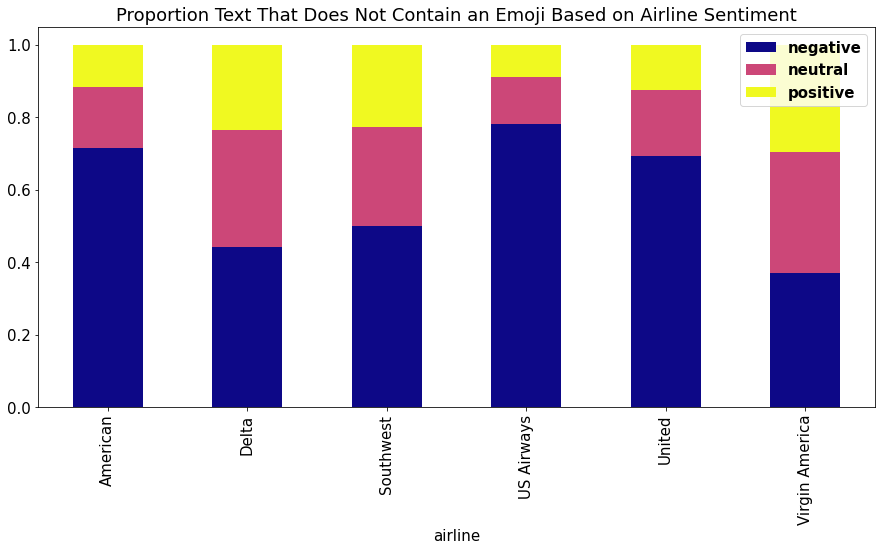

In [19]:
df = tweets[tweets["emoji"] == False]

df.groupby('airline')['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")
plt.title("Proportion Text That Does Not Contain an Emoji Based on Airline Sentiment")

plt.legend(loc="upper right")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

plt.show()

### EDA based on airline sentiment <a class="anchor" id="airlineSentimentEDA"></a>

#### View distribution of airline_sentiment_confidence

Text(0.5, 1.0, 'Airline Sentiment Confidence Distributions')

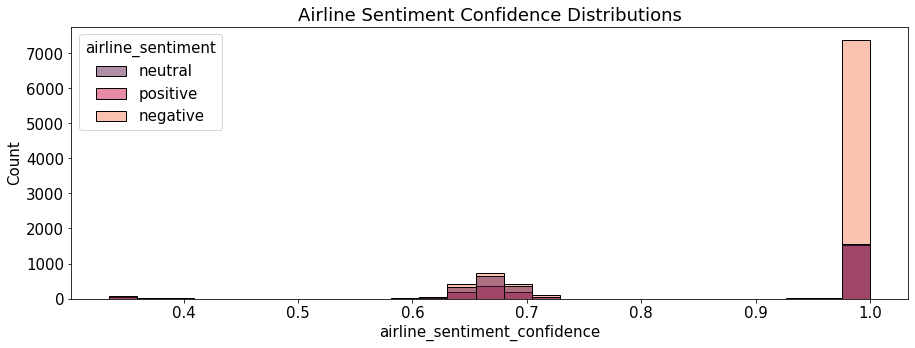

In [20]:
fig, axes = plt.subplots(figsize=(15, 5))
#sns.set_style("whitegrid")
axes = sns.histplot(tweets, x="airline_sentiment_confidence", hue="airline_sentiment", palette="rocket")
plt.title("Airline Sentiment Confidence Distributions")

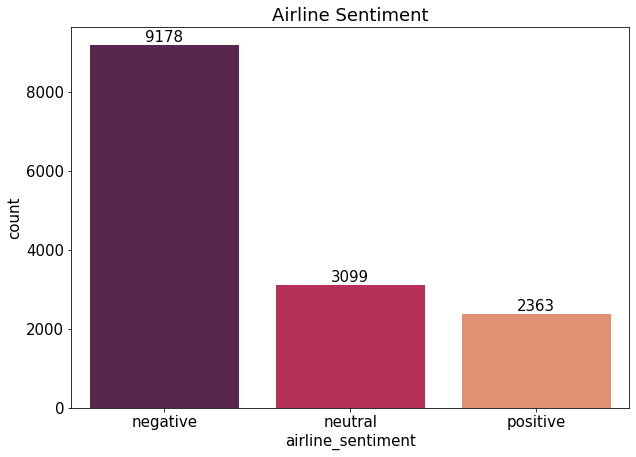

In [21]:
#see the difference between views
fig, axes = plt.subplots(figsize=(10, 7))
axes = sns.countplot(x="airline_sentiment", data=tweets, palette="rocket", order= tweets["airline_sentiment"].value_counts().index)

#sns.set_style("whitegrid")
plt.title("Airline Sentiment")

for container in axes.containers:
    axes.bar_label(container)

Text(0.5, 1.0, 'Airline Sentiment Proportion')

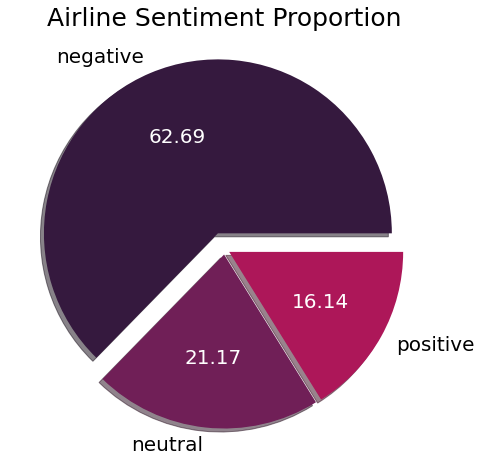

In [22]:
colors= sns.color_palette('rocket')
al = tweets["airline_sentiment"].value_counts()
myexplode = [0.10, 0.03, 0.03]

pie, ax = plt.subplots(figsize=[20,8])
_, _, autotexts = plt.pie(al, labels = al.keys(), colors=colors, autopct="%.2f", 
                          explode = myexplode, shadow=True, textprops={'fontsize': 20})

for ins in autotexts:
    ins.set_color('white')

plt.title("Airline Sentiment Proportion", fontsize=25)

In [23]:
from matplotlib import style
  
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


### Most of the sentiment is negative.

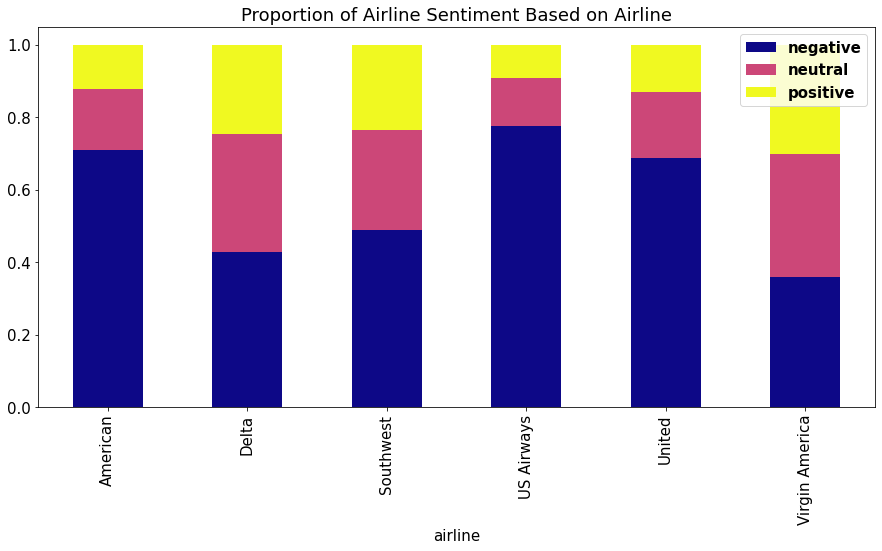

In [24]:
plt.rcParams["figure.figsize"] = (15,7)
plt.rcParams.update({'font.size': 15})

#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
tweets.groupby('airline')['airline_sentiment'].value_counts(
    normalize=True).unstack('airline_sentiment').plot.bar(stacked=True, cmap="plasma")
plt.title("Proportion of Airline Sentiment Based on Airline")

plt.legend(loc="upper right")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)

plt.show()

Text(0.5, 1.0, 'Airlines')

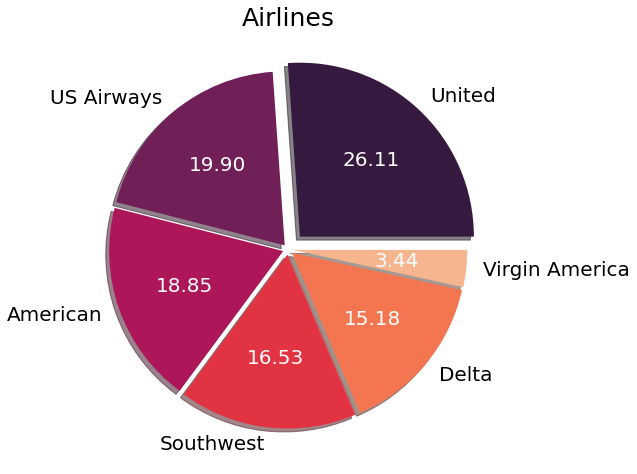

In [25]:
colors= sns.color_palette('rocket')
al = tweets["airline"].value_counts()
myexplode = [0.10, 0.03, 0.03, 0.03, 0.03, 0.03]
#sns.set_style("white")

pie, ax = plt.subplots(figsize=[20,8])
_, _, autotexts = plt.pie(al, labels = al.keys(), colors=colors, autopct="%.2f", 
                          explode = myexplode, shadow=True, textprops={'fontsize': 20})

for ins in autotexts:
    ins.set_color('white')

plt.title("Airlines", fontsize=25)

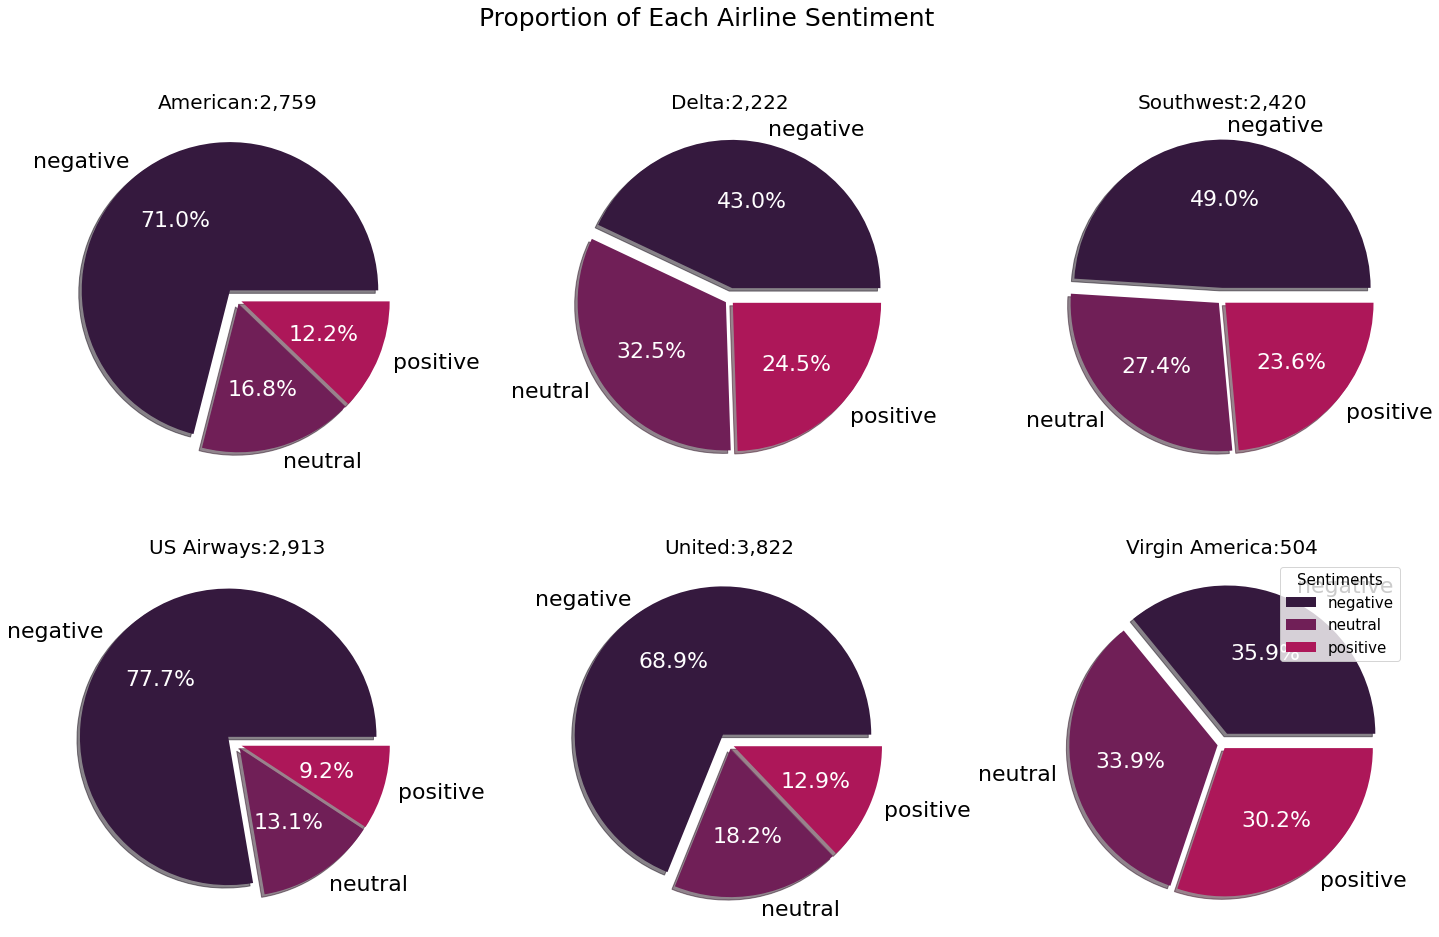

In [26]:
airlines = tweets.groupby(["airline", "airline_sentiment"])["airline_sentiment"].count().unstack()
colors= sns.color_palette('rocket')
myexplode = [0.08, 0.03, 0.03]
#sns.set_style("white")

fig, axes = plt.subplots(2, 3, figsize=(25, 15))
axes = axes.flatten()

for i, ax in zip(range(0, 6), axes):
    temp = airlines.iloc[i]
    #plt.rcParams.update({'font.size': 20})
    _, _, autotexts = ax.pie(x=temp, labels = temp.index, autopct="%.1f%%", colors=colors, 
           explode = myexplode, shadow = True, textprops={'fontsize': 22})
    ax.set_title(f"{airlines.index[i]}:{format(airlines.values[i].sum(),',')}", fontsize=20)
    for ins in autotexts:
        ins.set_color('white')
    
    
    
plt.suptitle("Proportion of Each Airline Sentiment", fontsize = 25)    
plt.legend(title = "Sentiments")
plt.show()

### View the amount of retweets in the tweet

In [27]:
#get the top and lowest tweet with retweet
print("The max retweets are: " + str(max(tweets["retweet_count"])))
print("The min retweets are: " + str(min(tweets["retweet_count"])))

The max retweets are: 44
The min retweets are: 0


In [28]:
tweets.sort_values("retweet_count", ascending="False" ).head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0     570306133677760513           neutral                           1.0   
9681  569720701197750272          negative                           1.0   
9682  569719964023853056          negative                           1.0   
9683  569719741906075648          negative                           1.0   
9684  569719242427396096          negative                           1.0   

              negativereason  negativereason_confidence         airline  \
0                        NaN                        NaN  Virgin America   
9681              Can't Tell                     1.0000      US Airways   
9682  Customer Service Issue                     0.6643      US Airways   
9683             Late Flight                     1.0000      US Airways   
9684        Cancelled Flight                     0.6987      US Airways   

             name  retweet_count  \
0         cairdin              0   
9681      jamokee              0   
9682       MelCMP              0   
9683  RishiKumar8              0   
9684       MelCMP              0   

                                                   text  \
0                       [virginamerica, dhepburn, said]   
9681                                 [usairways, worst]   
9682  [usairways, making, folk, run, gate, c, b, exp...   
9683  [usairways, waiting, airplane, total, hour, ta...   
9684  [usairways, given, option, new, flight, cant, ...   

                  tweet_created           tweet_location  \
0     2015-02-24 11:35:52 -0800                      NaN   
9681  2015-02-22 20:49:34 -0800  Sandy Eggo, California    
9682  2015-02-22 20:46:38 -0800             Pennsylvania   
9683  2015-02-22 20:45:46 -0800                      NaN   
9684  2015-02-22 20:43:46 -0800             Pennsylvania   

                   user_timezone  uppercase  emoji  polarity  word_count  
0     Eastern Time (US & Canada)   0.085714  False  0.000000           3  
9681                      Alaska   0.103448  False -1.000000           2  
9682  Eastern Time (US & Canada)   0.170543  False  0.000000          14  
9683                       Quito   0.022222  False -0.125000          11  
9684  Eastern Time (US & Canada)   0.071942  False -0.431818          15

#### EDA based on airline <a class="anchor" id="airlineEDA"></a>

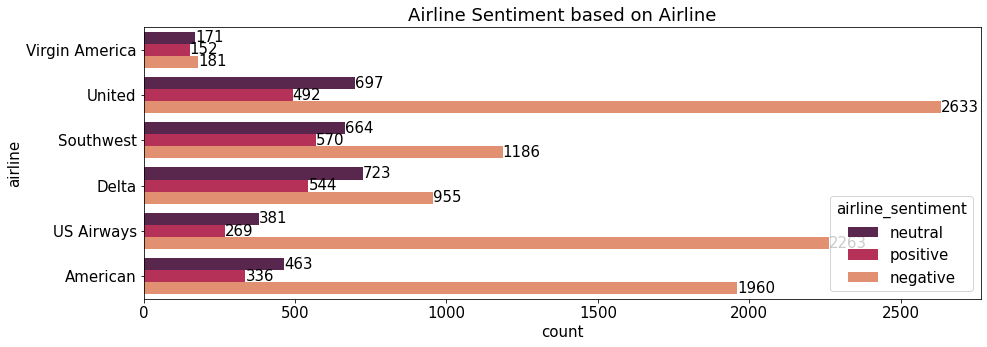

In [29]:
#sns.set_style("whitegrid")

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(y="airline", hue="airline_sentiment", data=tweets, palette="rocket")
plt.title("Airline Sentiment based on Airline")

for container in axes.containers:
    axes.bar_label(container)

# <b>Get the most predictive words by airline</b> <a class="anchor" id="pw"></a>


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

tweets["text"] = tweets["text"].astype(str)
#tweets = tweets.copy()
#tweets = tweets[tweets["airline_sentiment"] != "neutral"]

cv = CountVectorizer(min_df=50, max_df=0.70)
X = cv.fit_transform(tweets.text)
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)

lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)

In [31]:
words = np.array(cv.get_feature_names())

X = np.eye(X_test.shape[1])
probs = lr.predict_log_proba(X)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good Words")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad Words")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good Words
               thank 0.97
             booking 0.94
                  hi 0.94
              thanks 0.93
             amazing 0.92
               quick 0.92
              airway 0.91
             awesome 0.91
                best 0.91
                snow 0.90
Bad Words
                paid 0.27
          frustrated 0.27
              answer 0.26
               error 0.26
        unacceptable 0.25
             nothing 0.22
           complaint 0.21
          ridiculous 0.21
                fail 0.18
               worst 0.10


Method
Preprocess the text
Create term-document matrix with CountVectorizer
Train a predictive model on the matrix
Create an identity matrix the length of the vocabulary - so essentially we are creating a list of documents with the same vocabulary as our CountVectorizer, and each document is one word long - one for each word on the vocabulary
Use your model to predict on the identity matrix, and get a list of probabilities for each word
Connect the vocabulary to the probabilities (you can zip or use np.hstack or make a data frame with 2 columns)
Sort for most/least probable words for any give class
If words don’t make sense, experiment with min_df until they do (often min_df = 50 is good for this) 
you can just list these out, similarly to in the naive bayes assignment, you can also use the word_cloud module and use .generate_from_frequencies() method to create word clouds for most predictive and least predictive words
.generate_from_frequencies() allows you to input a dictionary rather than simply text, so you can input a dictionary with the words as the keys and their probabilities as the values

In [32]:
#make list of words
allWords = words[ind]
words = []

for w in allWords:
    w =  "{:>20}".format(w)
    words.append(w)

#words

#make list of prob
allProb = probs[ind]
probability = []

for p in allProb:
    p = "{:.2f}".format(1 - np.exp(p))
    probability.append(p)

#probability

In [33]:
predictiveWords = {"Words": words, "Probabilities": probability}

predictiveWords = pd.DataFrame(predictiveWords)
predictiveWords.head()

Words Probabilities
0                 thank          0.97
1               booking          0.94
2                    hi          0.94
3                thanks          0.93
4               amazing          0.92

In [34]:
#top predecticted words
predictiveWords[:10]

Words Probabilities
0                 thank          0.97
1               booking          0.94
2                    hi          0.94
3                thanks          0.93
4               amazing          0.92
5                 quick          0.92
6                airway          0.91
7               awesome          0.91
8                  best          0.91
9                  snow          0.90

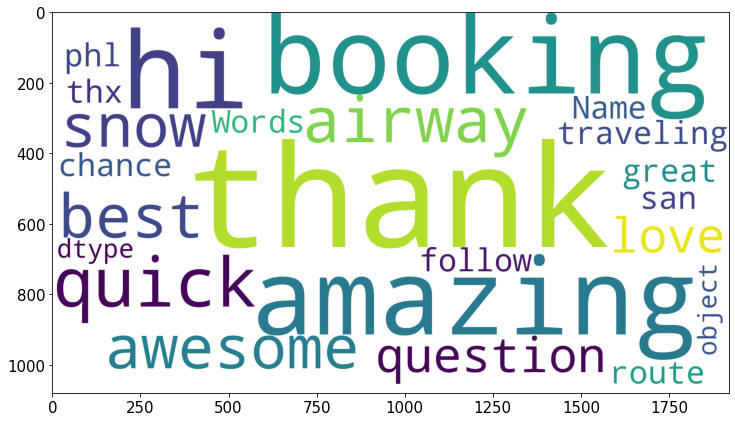

In [35]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
#sns.set_style("white")

wc = WordCloud(background_color = 'white', width = 1920, height = 1080)
cloud = wc.generate_from_text(str(predictiveWords[:20].Words))
plt.imshow(cloud)
plt.show()

In [36]:
#bottom predecticted words
predictiveWords[-10:]

Words Probabilities
467                  paid          0.27
468            frustrated          0.27
469                answer          0.26
470                 error          0.26
471          unacceptable          0.25
472               nothing          0.22
473             complaint          0.21
474            ridiculous          0.21
475                  fail          0.18
476                 worst          0.10

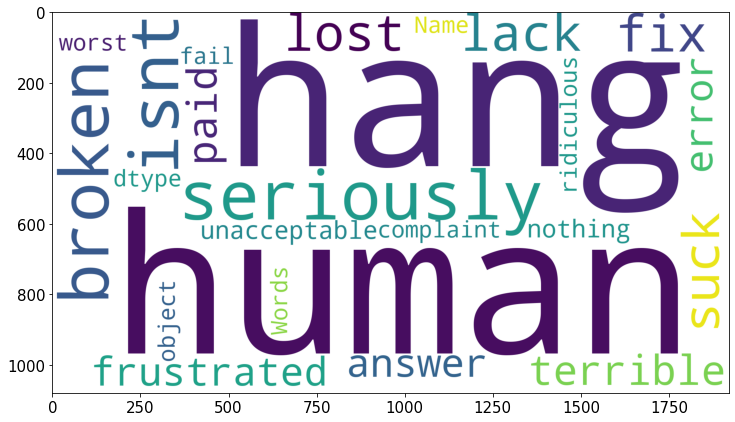

In [37]:
#sns.set_style("white")
wc = WordCloud(background_color = 'white', width = 1920, height = 1080)
cloud = wc.generate_from_text(str(predictiveWords[-20:].Words))
plt.imshow(cloud)
plt.show()

# Predictive words based on Airlines <a class="anchor" id="pwa"></a>

In [38]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def bad_good_words(airline, min_df):
    
    df = tweets.copy()
    
    df = df[df['airline']==airline]
    
    
    df["text"] = df["text"].astype(str)
    df = df[df["airline_sentiment"] != "neutral"]

    cv = CountVectorizer(min_df=min_df, max_df=0.70)
    X = cv.fit_transform(df.text)
    y = df['airline_sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)
    lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)


    words = np.array(cv.get_feature_names())

    X = np.eye(X_test.shape[1])
    probs = lr.predict_log_proba(X)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:10]]
    bad_words = words[ind[-10:]]

    good_prob = probs[ind[:10]]
    bad_prob = probs[ind[-10:]]
    
    df_good = pd.DataFrame(columns = ["good_word", "good_prob"])
    df_bad = pd.DataFrame(columns = ["bad_word", "bad_prob"])

    print("Good Words")
    for w, p in zip(good_words, good_prob):
        my_cmap = cm.get_cmap('plasma')
        my_norm = Normalize(vmin=0, vmax=8)
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
        df_good = df_good.append({"good_word": w, "good_prob": "{:.2f}".format(1 - np.exp(p))}, ignore_index=True)
    
    print("Bad Words")
    for w,p  in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
        df_bad = df_bad.append({"bad_word": w, "bad_prob": "{:.2f}".format(1 - np.exp(p))}, ignore_index=True)
        
    df_good["good_prob"] = pd.to_numeric(df_good["good_prob"])
    df_bad["bad_prob"] = pd.to_numeric(df_bad["bad_prob"])
    
    #fig, axes = plt.subplots(figsize=(15, 5))
    fig, axes = plt.subplots(2, 1, figsize=(25, 15))
    
    sns.barplot(x="good_word", y="good_prob", data=df_good, palette="rocket", 
                     order = df_good.sort_values("good_prob", ascending=False).good_word,
               ax=axes[0]).set(title="Good Words and Probabilities")
    sns.barplot(x="bad_word", y="bad_prob", data=df_bad, palette="rocket", 
                     order = df_bad.sort_values("bad_prob", ascending=False).bad_word,
               ax=axes[1]).set(title="Bad Words and Probabilities")

## United

Good Words
               thank 0.85
              thanks 0.77
               great 0.66
             amazing 0.60
                best 0.56
                good 0.52
          appreciate 0.50
                year 0.47
                made 0.46
          connecting 0.45
Bad Words
                 say 0.08
                  im 0.08
             already 0.08
               stuck 0.08
               would 0.08
              doesnt 0.07
             nothing 0.06
                want 0.05
               worst 0.05
                hour 0.05


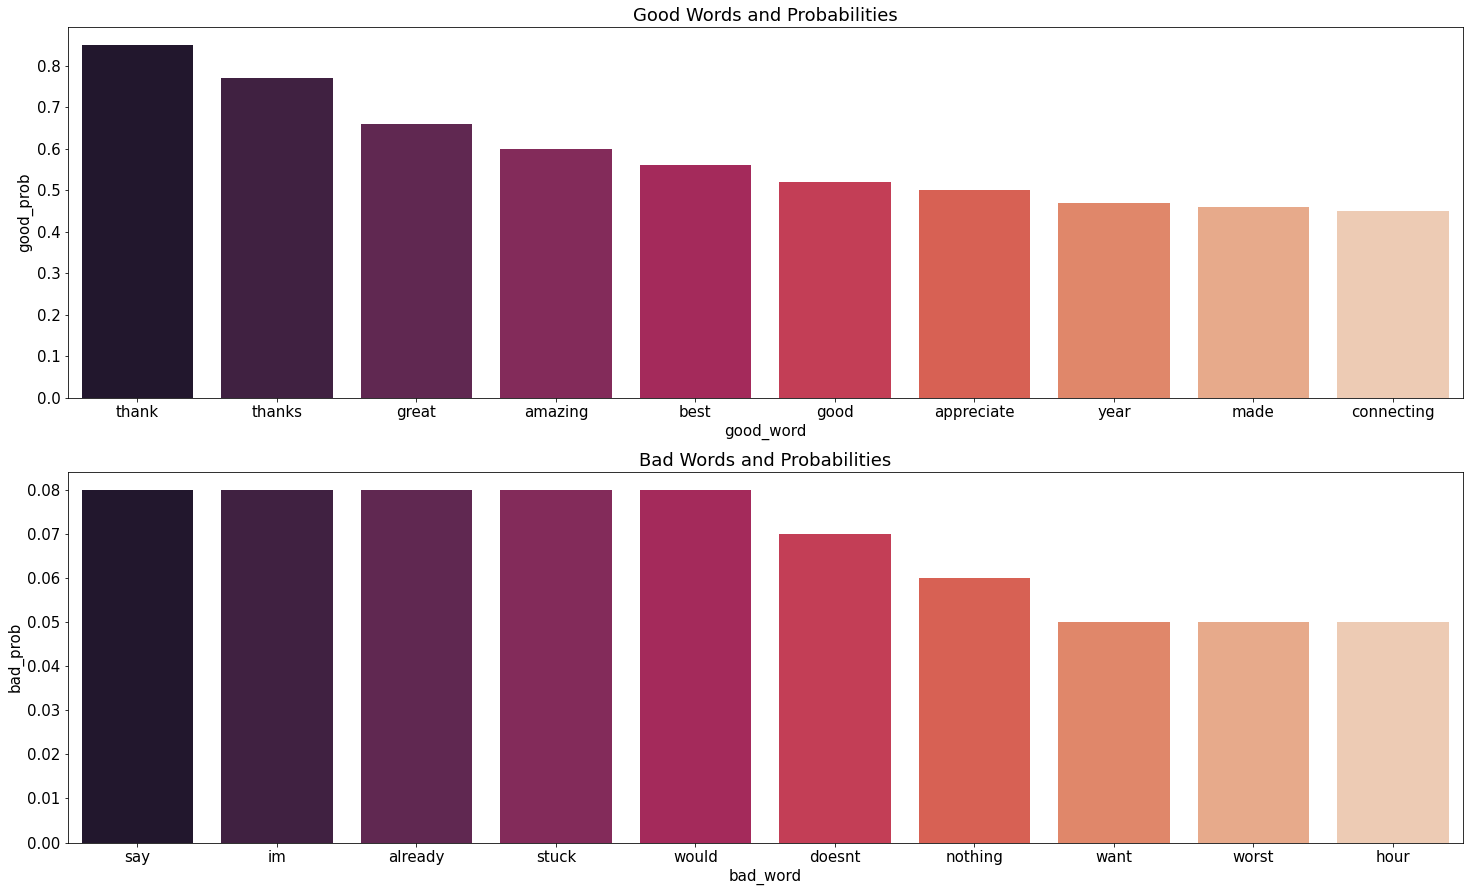

In [39]:
bad_good_words("United", 25)

In [40]:
def getWordContext(wordList, airline):
    #specific_words = wordList

    weirdDF =  pd.read_csv("../Data/Tweets.csv")
    pd.set_option("display.max_colwidth", -1)
    weirdDF = weirdDF[weirdDF["airline_sentiment"] != "neutral"]
    weirdDF = weirdDF[weirdDF["airline"] == airline]
    
    query = '|'.join(wordList)
 
    weirdDF['query_match'] = weirdDF["text"].str.contains(query, case=False)
    weirdDF['word'] = weirdDF["text"].str.extract( '({})'.format(query) )
    
    releventTweets = weirdDF[weirdDF["query_match"] == True]

    return releventTweets.head()

In [41]:
weirdWords = ["connecting"]
getWordContext(weirdWords, "United")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_83984/281950376.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
708   570160394494480384  negative          1.0                            
829   570060997907447810  negative          0.7                            
898   570026514923675648  negative          1.0                            
1407  569734991862607872  negative          1.0                            
1513  569689096882425857  negative          1.0                            

              negativereason  negativereason_confidence airline  \
708   Lost Luggage            1.0000                     United   
829   Late Flight             0.7000                     United   
898   Customer Service Issue  0.3639                     United   
1407  Customer Service Issue  1.0000                     United   
1513  Late Flight             0.6665                     United   

     airline_sentiment_gold             name negativereason_gold  \
708   NaN                    LukeGzus         NaN                  
829   NaN                    CharlieGMoney    NaN                  
898   NaN                    tpensari         NaN                  
1407  NaN                    ClaudiaMarrufo   NaN                  
1513  NaN                    sandyrojasstory  NaN                  

      retweet_count  \
708   0               
829   0               
898   0               
1407  0               
1513  0               

                                                                                                                                                 text  \
708   @united Thanks for remembering to load my bag onto my connecting flight. Oh wait you forgot. Iceland should be fun with no clothes....            
829   @united After our unscheduled refueling stop and missing 2 connecting flights we r home n looking 4ward to our bed and a big PB&amp;J sandwich.   
898   @united diverted and missed our connecting flight. Was just told that my bag is on it's way to MSY. If you only had people that cared             
1407  @united even after running to gate from your connecting flight, your customer service not let us in the plane that was just parked. Stranded      
1513  @united why is it that Sundays when my husband travels to Chicago he's stuck at Tarmac &amp; misses connecting flight always                      

                      tweet_coord              tweet_created tweet_location  \
708   NaN                          2015-02-24 01:56:45 -0800  NaN             
829   [41.98191311, -87.80888924]  2015-02-23 19:21:47 -0800  Chicago, IL     
898   NaN                          2015-02-23 17:04:46 -0800  NaN             
1407  NaN                          2015-02-22 21:46:21 -0800  EP TX           
1513  NaN                          2015-02-22 18:43:59 -0800  NaN             

                   user_timezone  query_match        word  
708   NaN                         True         connecting  
829   NaN                         True         connecting  
898   NaN                         True         connecting  
1407  Pacific Time (US & Canada)  True         connecting  
1513  NaN                         True         connecting

The top 10 best predictive words for United are the following: “thank”, “thanks”, “great”, “amazing”, “best”, “good”, “appreciate”, “year”, “made”, “connecting”

The top 10 worst predictive words are the following: “say”, “im”, “already”, “stuck”, “would”, “doesnt”, “nothing”, “want”, “worst”, “hour”.

Below are some context for some of the good predictive words.
		
1. “@united 18 flights so far this year. 13 delays including 2 Cancelled Flightations. Late Flightst reason, crew needed mandatory sleep. IN MEXICO!”
2. “@united No. Denver said they don't handle baggage that made it to Colo. Springs. They gave me an 800 number to call. No help there either.”
3. “@united Thanks for remembering to load my bag onto my connecting flight. Oh wait you forgot. Iceland should be fun with no clothes....”


## American

Good Words
               thank 0.90
              thanks 0.75
                love 0.63
               great 0.57
                 new 0.48
                nice 0.44
                good 0.44
                well 0.37
                best 0.32
             morning 0.32
Bad Words
                need 0.06
                hour 0.06
                  hr 0.06
             luggage 0.06
               worst 0.06
                 bag 0.06
                 try 0.05
                rude 0.05
                 due 0.05
                cant 0.05


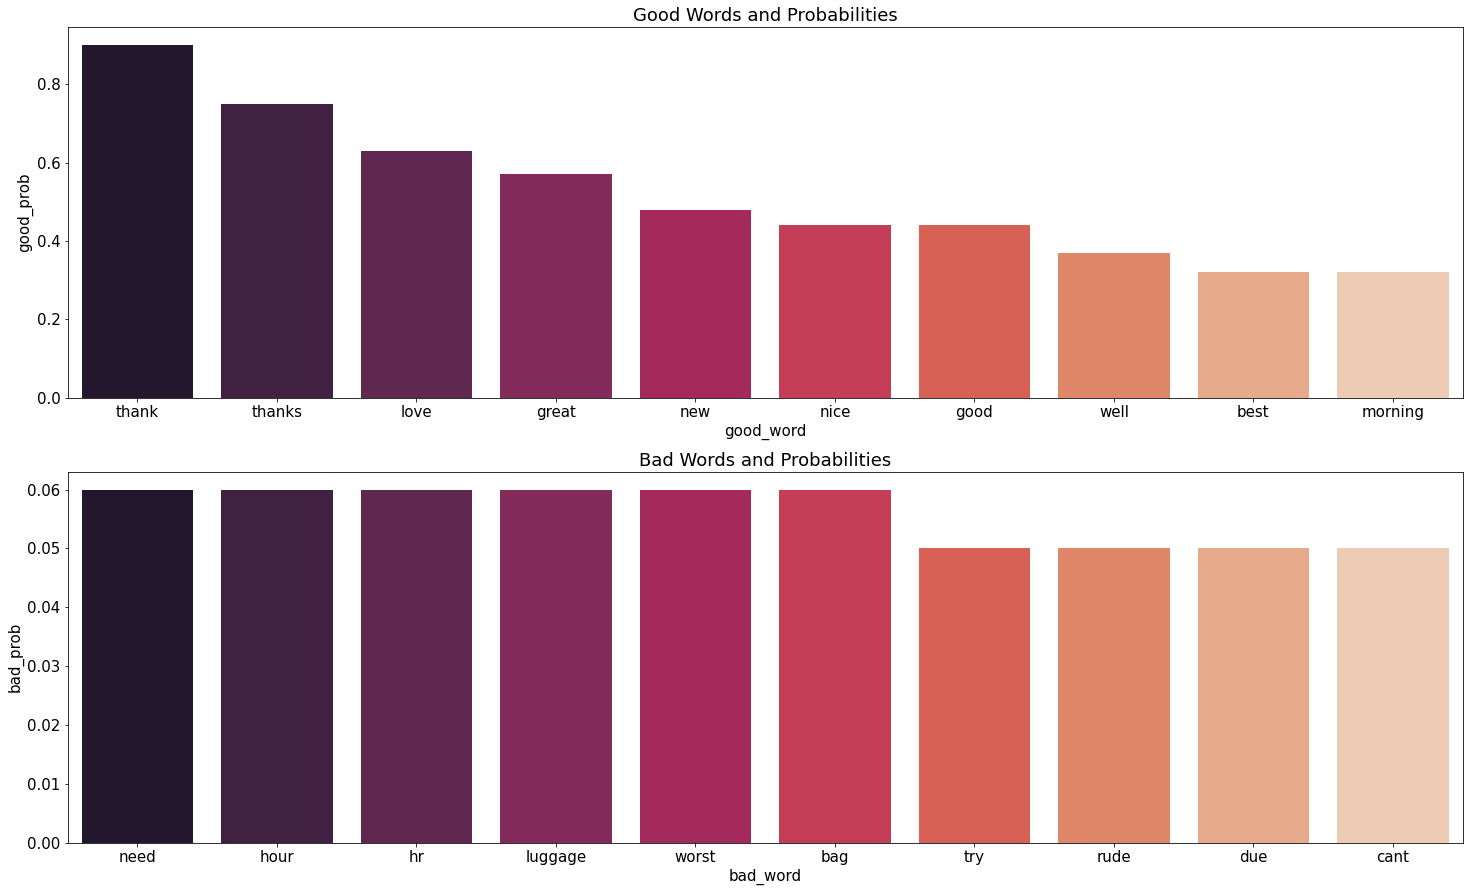

In [42]:
bad_good_words("American", 25)

In [43]:
weirdWords = ["morning"]
getWordContext(weirdWords, "American")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_83984/281950376.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
12316  570235209783717889  negative          1.0000                         
12354  570221471844278273  negative          1.0000                         
12428  570191763731841024  positive          0.6593                         
12441  570186533258416133  negative          1.0000                         
12478  570173690475728896  negative          1.0000                         

               negativereason  negativereason_confidence   airline  \
12316  Lost Luggage            1.0000                     American   
12354  Late Flight             0.3358                     American   
12428  NaN                    NaN                         American   
12441  Bad Flight              0.3496                     American   
12478  Customer Service Issue  1.0000                     American   

      airline_sentiment_gold            name negativereason_gold  \
12316  NaN                    JonKohler       NaN                  
12354  NaN                    Dumas2TTG       NaN                  
12428  NaN                    rkflyga         NaN                  
12441  NaN                    wbarkema        NaN                  
12478  NaN                    CamaroGuySteve  NaN                  

       retweet_count  \
12316  0               
12354  0               
12428  3               
12441  0               
12478  0               

                                                                                                                                                     text  \
12316  @AmericanAir I need to go to YYZ tmr morning 8am. I switched to United already, but my bag is still off in AA la-la land.                            
12354  “@AmericanAir: @Dumas2TTG Good morning, Tamara. We'll try to get you comfortably on a flight as soon as we can.”#NoXTraLegRoom #NoCoatCloset         
12428  @AmericanAir is rising like the sun at DCA this morning.  @NATCA members have the best view. #avgeek http://t.co/VAhdekVOKe                          
12441  @AmericanAir too Late Flight now. Boarded, exit rows taken. Could not have gotten worse. Guy next 2 me should've bought 2 seats. #miserablemorning   
12478  @AmericanAir you really need some customer service training for your unhappy EEs in the morning in Chicago. Gate K20 at 430 chking her schd          

      tweet_coord              tweet_created tweet_location  \
12316  NaN         2015-02-24 06:54:03 -0800  Denver, CO      
12354  NaN         2015-02-24 05:59:27 -0800  NaN             
12428  NaN         2015-02-24 04:01:24 -0800  KFDK            
12441  NaN         2015-02-24 03:40:37 -0800  NaN             
12478  NaN         2015-02-24 02:49:35 -0800  NaN             

                    user_timezone  query_match     word  
12316  Eastern Time (US & Canada)  True         morning  
12354  Arizona                     True         morning  
12428  Eastern Time (US & Canada)  True         morning  
12441  Central Time (US & Canada)  True         morning  
12478  NaN                         True         morning

 Below are some context for some of the good predictive words.

1. “@AmericanAir Its not that I wasn't offered "perks" by @USAirways. I ASKED and was told, "NO." #thenewamerican”
2. “@AmericanAir Aww cool! It's nice to know they are still up above my head then. One of my faves.”
3. “@AmericanAir Well I'm showing I am still sitting at the gate on the plane that has not departed?”
4. “@AmericanAir I need to go to YYZ tmr morning 8am. I switched to United already, but my bag is still off in AA la-la land.”


## Delta

Good Words
              thanks 0.92
               thank 0.83
             awesome 0.81
                love 0.80
               great 0.80
                best 0.78
              always 0.67
                next 0.60
                know 0.60
               first 0.60
Bad Words
               plane 0.17
                late 0.17
               still 0.15
                 ive 0.15
             someone 0.13
           cancelled 0.12
               delay 0.12
                 bag 0.12
             delayed 0.12
                hour 0.08


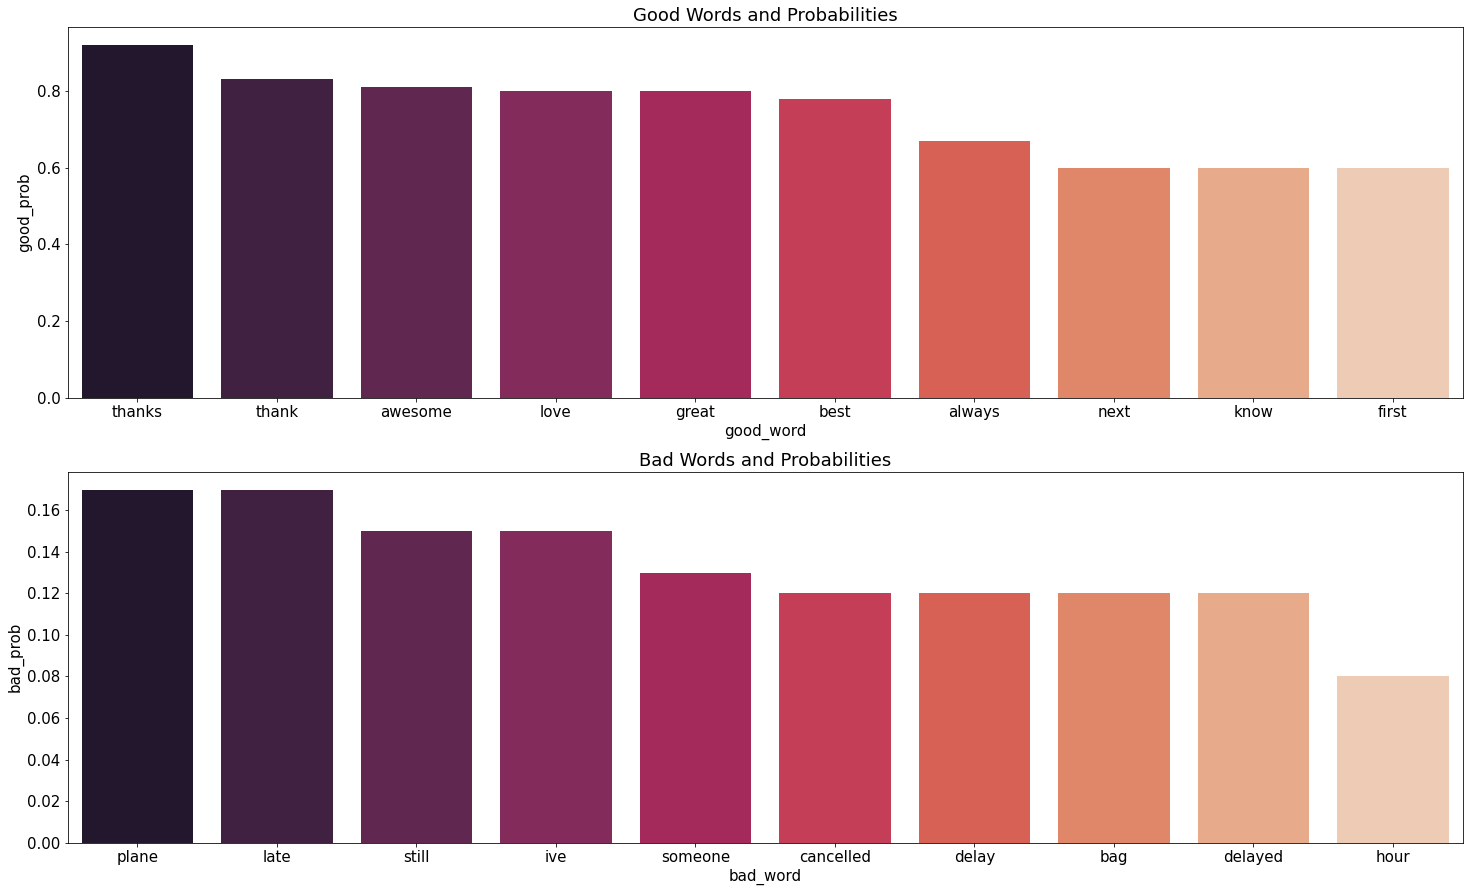

In [44]:
bad_good_words("Delta", min_df=20)

In [45]:
weirdWords = ["first"]
getWordContext(weirdWords, "Delta")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_83984/281950376.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
6805  570244951914782721  positive          0.6429                         
6806  570243767585935360  positive          0.6578                         
6839  570206077826039808  positive          0.6633                         
6869  570077234570010624  negative          1.0000                         
7135  569926945535860736  positive          1.0000                         

                   negativereason  negativereason_confidence airline  \
6805  NaN                          0.0000                     Delta    
6806  NaN                         NaN                         Delta    
6839  NaN                         NaN                         Delta    
6869  Flight Attendant Complaints  0.6718                     Delta    
7135  NaN                         NaN                         Delta    

     airline_sentiment_gold            name negativereason_gold  \
6805  NaN                    PaulParz        NaN                  
6806  NaN                    gabs_tweets     NaN                  
6839  NaN                    jannasaurusrex  NaN                  
6869  NaN                    williamzitser   NaN                  
7135  NaN                    getmeontop      NaN                  

      retweet_count  \
6805  0               
6806  0               
6839  0               
6869  0               
7135  0               

                                                                                                                                        text  \
6805  @JetBlue you don't need to cut services, charge more and give a better flying experience. That's why I use jet blue in the first place   
6806  @JetBlue Longing to look into the blue eyes. #firstlove                                                                                  
6839  @JetBlue boarding the back of the airplane first. Like a boss. #sosmart #jetblue #frequentflyerappreciates #alsoyayforsnacks             
6869  @JetBlue we have. Twice. They said they can't dim those lights. But they did on our first flight.                                        
7135  @JetBlue Very excited, for the first time this Sunday, March 1 I get to fly #JetBlue flight 123 #Mint from JFK. Looking forward :-)      

     tweet_coord              tweet_created                  tweet_location  \
6805  NaN         2015-02-24 07:32:45 -0800  NaN                              
6806  NaN         2015-02-24 07:28:03 -0800  NaN                              
6839  NaN         2015-02-24 04:58:17 -0800  central mass                     
6869  NaN         2015-02-23 20:26:18 -0800  NYC                              
7135  [0.0, 0.0]  2015-02-23 10:29:07 -0800  Wall Street • Manhattan • NYC    

                   user_timezone  query_match   word  
6805  NaN                         True         first  
6806  Eastern Time (US & Canada)  True         first  
6839  NaN                         True         first  
6869  Central Time (US & Canada)  True         first  
7135  Eastern Time (US & Canada)  True         first

Below are some context for some of the good predictive words.

1. “@JetBlue just wondering if the website is having issues today. Trying to book a flight with my visa I always use and its rejecting it.”
2. “@JetBlue but by Cancelled Flighting my flight and pushing me to the next day I'd lose $150 hotel which was why I was trying to get a same-day flight.”
3. “@JetBlue it will be glowing. Your crew and your aircraft sparkled. You guys know about @nokidhungry right? Might be a good partnership:)”
4. “@JetBlue boarding the back of the airplane first. Like a boss. #sosmart #jetblue #frequentflyerappreciates #alsoyayforsnacks”


## Southwest

Good Words
               thank 0.91
              thanks 0.88
             awesome 0.86
                best 0.85
                crew 0.81
                love 0.79
               great 0.72
          appreciate 0.68
             finally 0.66
                trip 0.62
Bad Words
              online 0.16
                  hr 0.15
                 bag 0.15
           cancelled 0.15
            boarding 0.14
             luggage 0.13
                hold 0.13
               worst 0.11
             someone 0.11
                hour 0.10


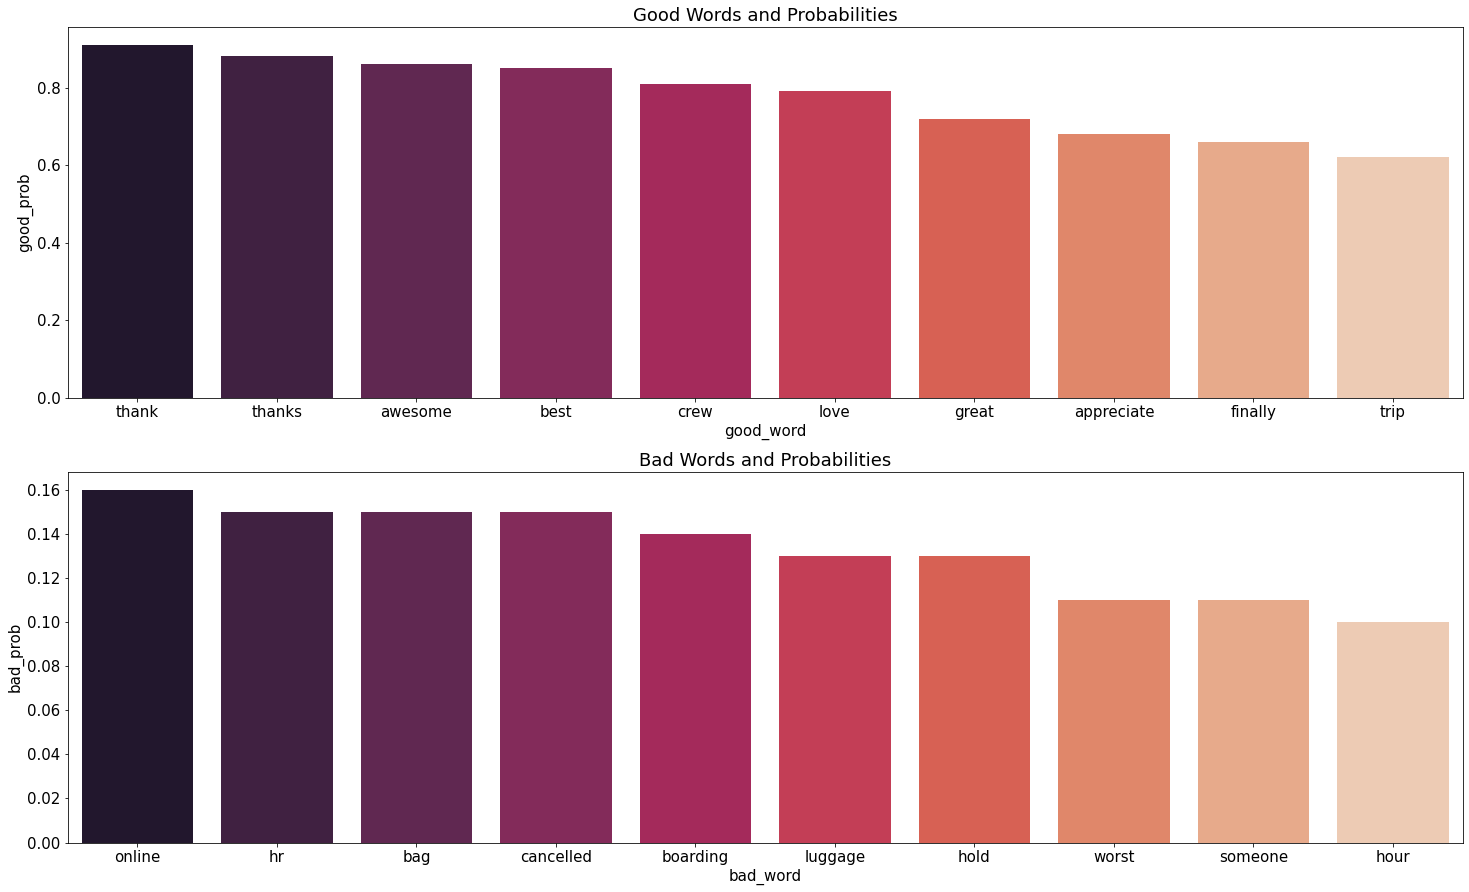

In [46]:
bad_good_words("Southwest", 25)

In [47]:
weirdWords = ["trip"]
getWordContext(weirdWords, "Southwest")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_83984/281950376.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
4347  570294002077061120  positive          1.0000                         
4372  570283824040382464  positive          1.0000                         
4426  570261514340474880  negative          1.0000                         
4444  570252231624265729  negative          1.0000                         
4454  570246490473566208  negative          0.6458                         

              negativereason  negativereason_confidence    airline  \
4347  NaN                    NaN                         Southwest   
4372  NaN                    NaN                         Southwest   
4426  Customer Service Issue  0.6382                     Southwest   
4444  Customer Service Issue  0.6680                     Southwest   
4454  Customer Service Issue  0.6458                     Southwest   

     airline_sentiment_gold             name negativereason_gold  \
4347  NaN                    catjubs          NaN                  
4372  NaN                    VolunteerLBK     NaN                  
4426  NaN                    island_girl4321  NaN                  
4444  NaN                    ckramer          NaN                  
4454  NaN                    NecroticDoctor   NaN                  

      retweet_count  \
4347  0               
4372  0               
4426  0               
4444  0               
4454  0               

                                                                                                                                                  text  \
4347  @SouthwestAir  thanks Southwest for saving our trip. my sweetheart isn't going to miss seeing #AltonBrownLive thanks to y'all! #SOhappy            
4372  @SouthwestAir round-trip tickets just arrived for our auction at the Post-Masters Invitational! Thanks Southwest! http://t.co/mRfBjtePef           
4426  @SouthwestAir  on hold with customer service; you may be quicker.  I rebooked trip for a lower fare.  Where did the difference in $ go?            
4444  @SouthwestAir Why can we no longer change trips with a companion online? Been doing it for years, now get message can't be done online?            
4454  @SouthwestAir Is there a way to receive a refund on a trip that was Cancelled Flight online instead of calling? Your phone lines are super busy.   

     tweet_coord              tweet_created            tweet_location  \
4347  NaN         2015-02-24 10:47:40 -0800  lurking in a coffeehouse   
4372  NaN         2015-02-24 10:07:13 -0800  Lubbock, TX                
4426  NaN         2015-02-24 08:38:34 -0800  NaN                        
4444  NaN         2015-02-24 08:01:41 -0800  Orlando, Florida           
4454  NaN         2015-02-24 07:38:52 -0800  Trapped in Baltimore.      

                   user_timezone  query_match  word  
4347  Pacific Time (US & Canada)  True         trip  
4372  Central Time (US & Canada)  True         trip  
4426  NaN                         True         trip  
4444  Eastern Time (US & Canada)  True         trip  
4454  Atlantic Time (Canada)      True         trip

Below are some context for some of the good predictive words.

1. “@SouthwestAir crew on flight 206 is awesome! Tell them I sent this tweet and maybe they will give me free wifi... #canthurtasking”
2. “@SouthwestAir After multiple attempts, I was finally able to submit them Late Flight last night”
3. “@SouthwestAir Why can we no longer change trips with a companion online? Been doing it for years, now get message can't be done online?”

## US Airways

Good Words
               thank 0.81
              thanks 0.70
               great 0.55
             awesome 0.54
                best 0.51
                 thx 0.47
                away 0.45
               kudos 0.44
                crew 0.41
          appreciate 0.41
Bad Words
                 bad 0.07
               never 0.07
              reason 0.07
             luggage 0.06
                mile 0.06
             nothing 0.06
                need 0.06
                call 0.06
                hold 0.04
                hour 0.04


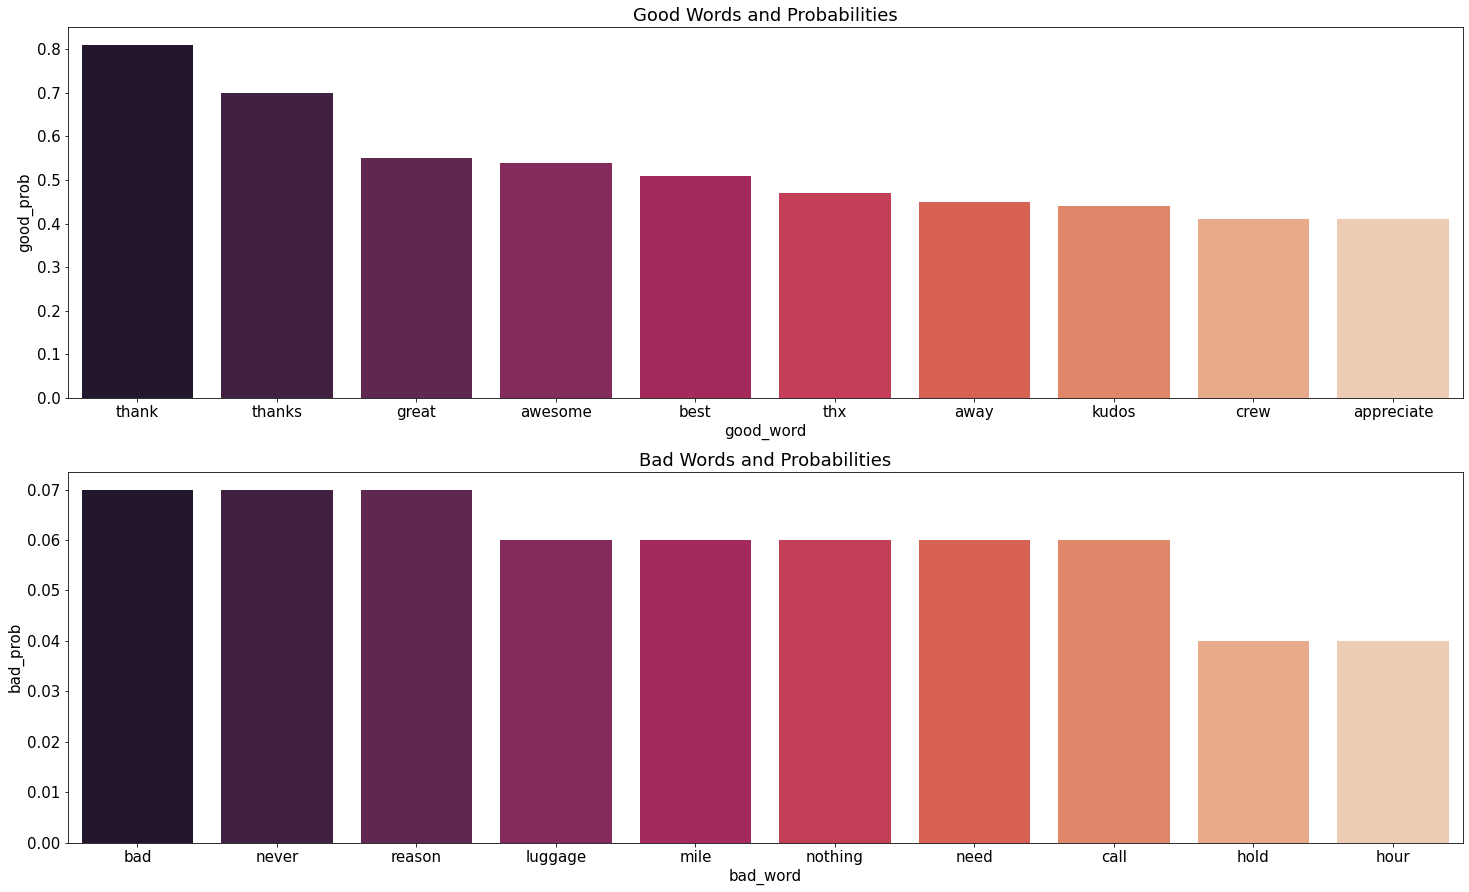

In [48]:
bad_good_words("US Airways", 5)

In [49]:
weirdWords = [ "crew"]
getWordContext(weirdWords, "US Airways")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_83984/281950376.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
8977  570304779412508673  negative          1.0                            
9092  570231607757381632  negative          1.0                            
9145  570119853312311296  positive          1.0                            
9177  570083458925490176  negative          1.0                            
9244  570030590466121728  positive          1.0                            

              negativereason  negativereason_confidence     airline  \
8977  Customer Service Issue  0.7072                     US Airways   
9092  Late Flight             1.0000                     US Airways   
9145  NaN                    NaN                         US Airways   
9177  Late Flight             1.0000                     US Airways   
9244  NaN                    NaN                         US Airways   

     airline_sentiment_gold           name negativereason_gold  retweet_count  \
8977  NaN                    TheOnlyJasonS  NaN                 1               
9092  NaN                    MadeleineDay   NaN                 0               
9145  NaN                    GrahamHaigh    NaN                 0               
9177  NaN                    premiyerx      NaN                 0               
9244  NaN                    golfowens      NaN                 0               

                                                                                                                                                  text  \
8977  @USAirways always fun to get screwed out of an earlier flight (that isn't full) #crummyservice #whydidntiflysouthwest #goodluckamericanair         
9092  @USAirways @AmericanAir our honeymoon was delayed a day because a gas cap was not screwed on! Flight 1801- so frustrating!                         
9145  @usairways great crew for flight 504 PHX to YVR tonight! Friendly, efficient. Awesome job.                                                         
9177  @USAirways screwed me up big. 1st flight 1hr Late Flight. Made it to 2nd flight. CSM daryl wouldn't let me on the plane because we were (1/4)      
9244  @USAirways good work by flight 1798 crew.  #Chairman's recognition even in coach.  Too many #missedupgrades Late Flightly.  What's up with this?   

                      tweet_coord              tweet_created  \
8977  NaN                          2015-02-24 11:30:29 -0800   
9092  NaN                          2015-02-24 06:39:44 -0800   
9145  NaN                          2015-02-23 23:15:40 -0800   
9177  NaN                          2015-02-23 20:51:02 -0800   
9244  [35.22177192, -80.92309308]  2015-02-23 17:20:58 -0800   

                    tweet_location               user_timezone  query_match  \
8977  NaN                           NaN                         True          
9092  St. Louis                     Pacific Time (US & Canada)  True          
9145  Vancouver, Canada             Pacific Time (US & Canada)  True          
9177  Dallas, TX                    NaN                         True          
9244  Charleston, SC and the Earth  NaN                         True          

      word  
8977  crew  
9092  crew  
9145  crew  
9177  crew  
9244  crew

Below are some context for some of the good predictive words.

1. “@USAirways And you took away my 1st class seat. Love being a Chairman Preferred and assigned row 24 seat B middle seat”
2. “@USAirways always fun to get screwed out of an earlier flight (that isn't full) #crummyservice #whydidntiflysouthwest #goodluckamericanair”
3. “@usairways great crew for flight 504 PHX to YVR tonight! Friendly, efficient. Awesome job.”

## Virgin America

Good Words
                love 0.88
              thanks 0.84
               great 0.82
                cool 0.82
                best 0.82
               route 0.76
               thank 0.76
             awesome 0.74
              virgin 0.73
             amazing 0.73
Bad Words
                 jfk 0.36
                week 0.33
               check 0.33
             delayed 0.32
            customer 0.32
                help 0.32
             problem 0.31
           cancelled 0.31
                seat 0.23
             website 0.18


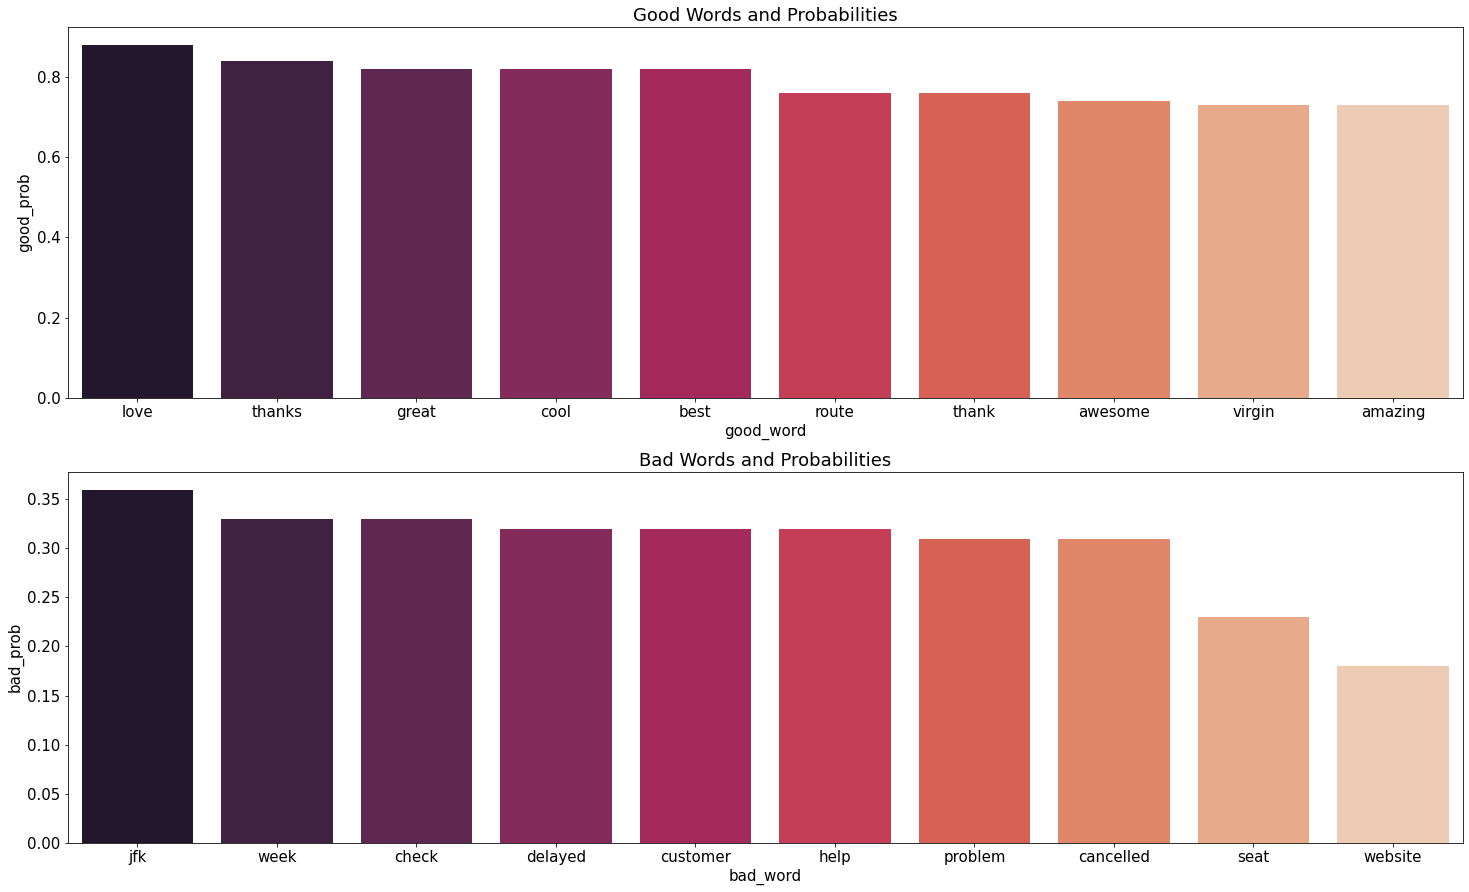

In [50]:
bad_good_words("Virgin America", 7)

In [51]:
weirdWords = [ "virgin"]
getWordContext(weirdWords, "Virgin America")

/var/folders/4s/dkl5yc9543jbyd5lrgf388vh0000gp/T/ipykernel_83984/281950376.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


tweet_id airline_sentiment  airline_sentiment_confidence  \
1  570301130888122368  positive          0.3486                         
3  570301031407624196  negative          1.0000                         
4  570300817074462722  negative          1.0000                         
5  570300767074181121  negative          1.0000                         
6  570300616901320704  positive          0.6745                         

  negativereason  negativereason_confidence         airline  \
1  NaN            0.0000                     Virgin America   
3  Bad Flight     0.7033                     Virgin America   
4  Can't Tell     1.0000                     Virgin America   
5  Can't Tell     0.6842                     Virgin America   
6  NaN            0.0000                     Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
1  NaN                    jnardino    NaN                 0               
3  NaN                    jnardino    NaN                 0               
4  NaN                    jnardino    NaN                 0               
5  NaN                    jnardino    NaN                 0               
6  NaN                    cjmcginnis  NaN                 0               

                                                                                                                                       text  \
1  @VirginAmerica plus you've added commercials to the experience... tacky.                                                                   
3  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse             
4  @VirginAmerica and it's a really big bad thing about it                                                                                    
5  @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA   
6  @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)                                                            

  tweet_coord              tweet_created    tweet_location  \
1  NaN         2015-02-24 11:15:59 -0800  NaN                
3  NaN         2015-02-24 11:15:36 -0800  NaN                
4  NaN         2015-02-24 11:14:45 -0800  NaN                
5  NaN         2015-02-24 11:14:33 -0800  NaN                
6  NaN         2015-02-24 11:13:57 -0800  San Francisco CA   

                user_timezone  query_match word  
1  Pacific Time (US & Canada)  True         NaN  
3  Pacific Time (US & Canada)  True         NaN  
4  Pacific Time (US & Canada)  True         NaN  
5  Pacific Time (US & Canada)  True         NaN  
6  Pacific Time (US & Canada)  True         NaN

Below are some context for some of the good predictive words.

1. “@VirginAmerica your beautiful front-end design is down right now; but it was cool to still book my ticket b/c all your back-end was secure.”
2. “@VirginAmerica Just bought tix for ATX - Dallas route - thanks for adding that! Love yr airline &amp; yr website is BEST transactional site EVER”

# Lime

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

df = tweets.copy()
df = df[df["airline_sentiment"] != "neutral"]
df["text"] = df["text"].astype(str)

list_corpus = df["text"].tolist()
list_labels = df["airline_sentiment"].tolist()
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = 'english', binary=True)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

logreg = LogisticRegression(C=1, max_iter=1000)
logreg.fit(train_vectors, y_train)
pred = logreg.predict(test_vectors)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.901, precision = 0.897, recall = 0.901, f1 = 0.897


In [53]:
c = make_pipeline(vectorizer, logreg)
class_names=list(df.airline_sentiment.unique())
explainer = LimeTextExplainer(class_names=class_names)

idx = 187
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, labels=[1])
print('Document id: %d' % idx)
#print('Predicted class =', class_names[logreg.predict(test_vectors[idx].reshape(1,-1))])
#print('True class: %s' % class_names[y_test[idx]])

Document id: 187


In [54]:
#.reshape(1,-1)[0,0]]

In [55]:
#negative sentiment 
print ('Explanation for class %s' % class_names[1])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class negative
('thanks', 0.5597840319779195)
('helpful', 0.08653045480624631)
('ask', -0.06997525561141574)
('jfk', -0.053609785703145535)
('incredibly', -0.04881906403026679)
('jetblue', 0.04253089688021044)


In [56]:
#positive sentiment
print ('Explanation for class %s' % class_names[0])
print ('\n'.join(map(str, exp.as_list(label=1))))

Explanation for class positive
('thanks', 0.5597840319779195)
('helpful', 0.08653045480624631)
('ask', -0.06997525561141574)
('jfk', -0.053609785703145535)
('incredibly', -0.04881906403026679)
('jetblue', 0.04253089688021044)


In [57]:
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

[1, 0]


In [58]:
exp.show_in_notebook(text=False)

It's predicting that most of the tweets are negative (90%). 

In [59]:
exp.show_in_notebook(text=y_test[idx], labels=(1,))

I zoomed in and study the explanations for class negative as well as the document itself.

### Let's look at the negative reason

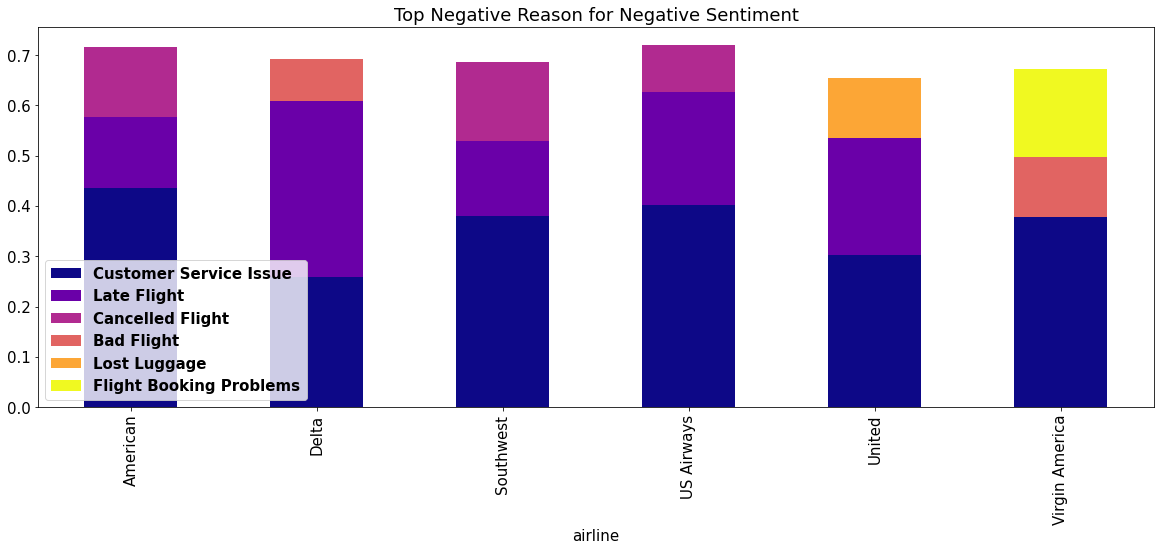

In [60]:
plt.rcParams["figure.figsize"] = (20,7)
plt.rcParams.update({'font.size': 15})

#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')


top = tweets[tweets["negativereason"] != "Can't Tell"]
top = top.groupby("airline")["negativereason"].value_counts(normalize=True).to_frame()
top = top.dropna(how='any')

top = top.groupby('airline')['negativereason'].head(3)
top.unstack('negativereason').plot.bar(stacked=True, cmap="plasma")

plt.title("Top Negative Reason for Negative Sentiment")

#plt.legend(loc="upper left")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties, loc="lower left")

plt.show()

In [61]:
import re
#s='abcd2343 abw34324 abc3243-23A'
#re.split('(\d+)',s)

df = tweets[tweets["negativereason"] != "Can't Tell"]
df = df.groupby('airline')['negativereason'].value_counts().to_frame()
df = df.groupby('airline')['negativereason'].head()

#df = df.to_frame()
type(df)
#df = df.reset_index(drop=False)
df

airline         negativereason             
American        Customer Service Issue         768
                Late Flight                    249
                Cancelled Flight               246
                Lost Luggage                   149
                Flight Booking Problems        130
Delta           Late Flight                    269
                Customer Service Issue         199
                Bad Flight                     64 
                Flight Attendant Complaints    60 
                Lost Luggage                   57 
Southwest       Customer Service Issue         391
                Cancelled Flight               162
                Late Flight                    152
                Bad Flight                     90 
                Lost Luggage                   90 
US Airways      Customer Service Issue         811
                Late Flight                    453
                Cancelled Flight               189
                Lost Luggage          

Text(0.5, 1.0, 'Negative Reason for Negative Sentiment')

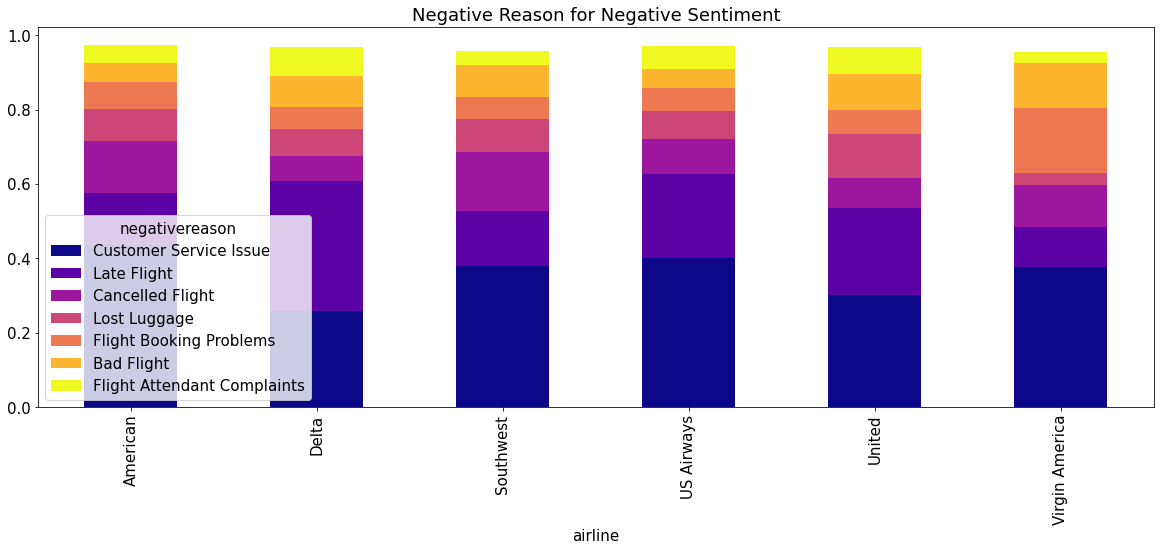

In [62]:
df = tweets[tweets["negativereason"] != "Can't Tell"]
df = df[["airline", "negativereason"]]
df = df.dropna(how='any')

df = df.groupby(['airline']).negativereason.value_counts(normalize=True).to_frame()
df = df.groupby('airline')['negativereason'].head(7)
df.unstack('negativereason').plot.bar(stacked=True, cmap="plasma")


plt.title("Negative Reason for Negative Sentiment")

### Date vs Airline Sentiment <a class="anchor" id="Date"></a>

In [63]:
from datetime import datetime

#convert tweet created column to datetime
tweets["tweet_created"] = pd.to_datetime(tweets["tweet_created"])

#drop timestmp 
tweets["tweet_created"] = tweets["tweet_created"].dt.date

#tweets.head(3)

# group by date , airline, and airline sentiment 
tweetGroup = tweets.groupby(["tweet_created", "airline", "airline_sentiment"]).size()
tweetGroup

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative             1  
                               neutral              1  
               United          negative             2  
2015-02-17     Delta           negative             108
                               neutral              86 
                                                    .. 
2015-02-24     United          neutral              49 
                               positive             25 
               Virgin America  negative             10 
                               neutral              6  
                               positive             13 
Length: 136, dtype: int64

The tweets are between Feb. 16, 2015 and Feb 24, 2015

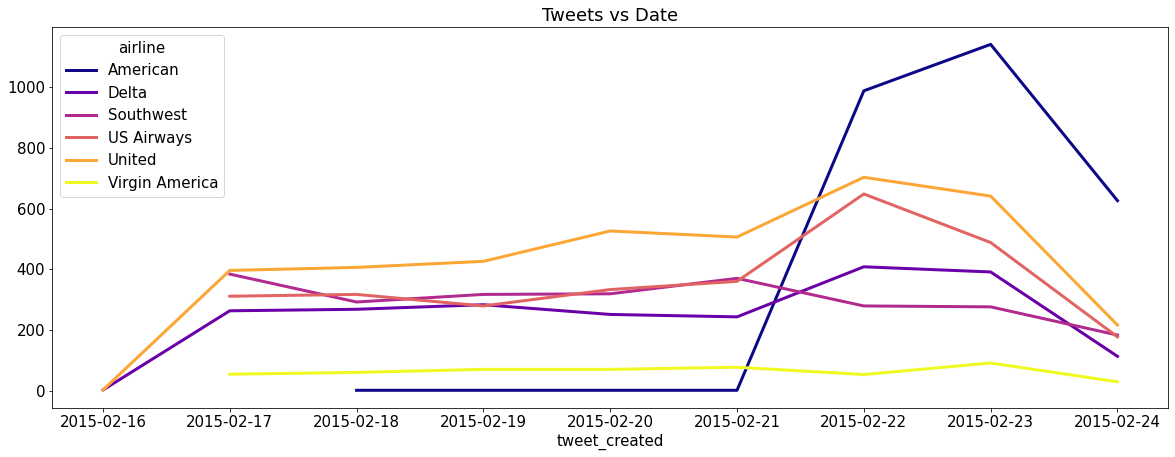

In [64]:
# All tweets per date
#fig, axes = plt.subplots(figsize=(15, 5))

allTweets = tweets.groupby(["tweet_created", "airline"])["tweet_id"].count()
allTweets.unstack().plot(cmap="plasma", linewidth=3)

plt.title("Tweets vs Date")
plt.show()

In [65]:
negTweets = tweets[tweets["airline_sentiment"] == 'negative']

dailySum = negTweets.groupby("tweet_created")["tweet_id"].count()
#daily =  
dailySum

tweet_created
2015-02-16    3   
2015-02-17    838 
2015-02-18    736 
2015-02-19    751 
2015-02-20    835 
2015-02-21    1049
2015-02-22    2266
2015-02-23    1919
2015-02-24    781 
Name: tweet_id, dtype: int64

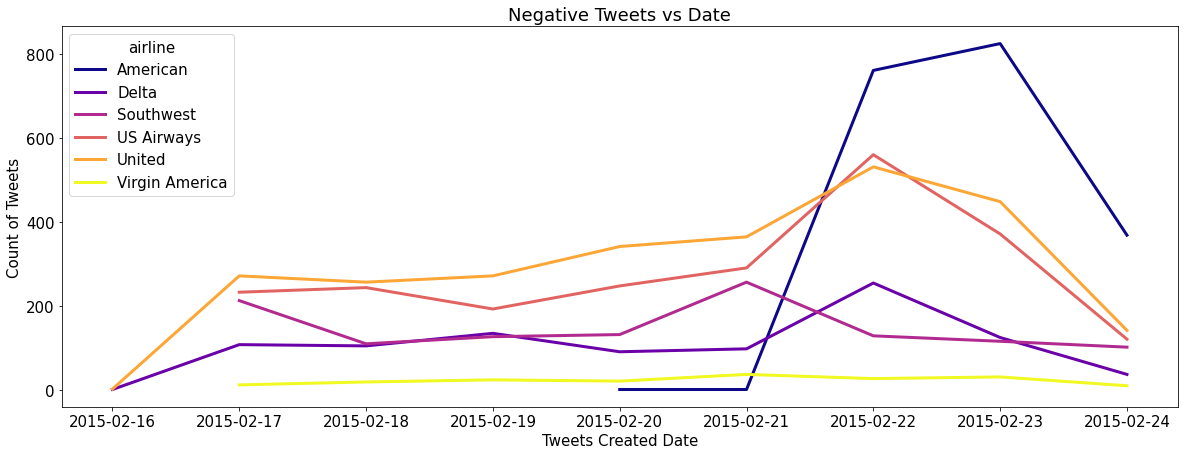

In [66]:
### NEGATIVE TWEETS VS DATE ###
import matplotlib.ticker as mtick


negTweets = tweets[tweets["airline_sentiment"] == 'negative']
negTweets = negTweets.groupby(["tweet_created", "airline"])["tweet_id"].count()
negTweets.unstack().plot(cmap="plasma", linewidth=3)

plt.title("Negative Tweets vs Date")
plt.xlabel("Tweets Created Date")
plt.ylabel("Count of Tweets")

plt.show()

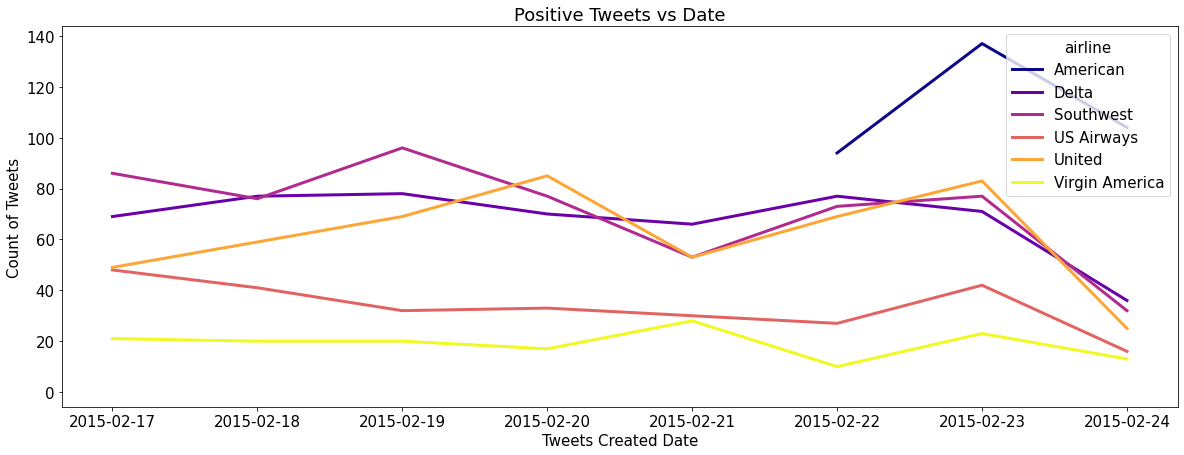

In [67]:
# Positive tweets per date
posTweets = tweets[tweets["airline_sentiment"] == 'positive']
posTweets = posTweets.groupby(["tweet_created", "airline"])["tweet_id"].count()
posTweets.unstack().plot(cmap="plasma", linewidth=3)


plt.title("Positive Tweets vs Date")
plt.xlabel("Tweets Created Date")
plt.ylabel("Count of Tweets")
plt.show()


## user_timezone  <a class="anchor" id="user_timezone"></a>

In [68]:
#number of timezones 
tweets.user_timezone.nunique()

85

In [69]:
topTZ = tweets.user_timezone.value_counts().head(10)
topTZ = topTZ.to_frame()
topTZ = topTZ.reset_index()
topTZ = topTZ.rename(columns={"index": "Timezone", "user_timezone": "Count"})
topTZ.head()

Timezone  Count
0  Eastern Time (US & Canada)  3744 
1  Central Time (US & Canada)  1931 
2  Pacific Time (US & Canada)  1208 
3  Quito                       738  
4  Atlantic Time (Canada)      497

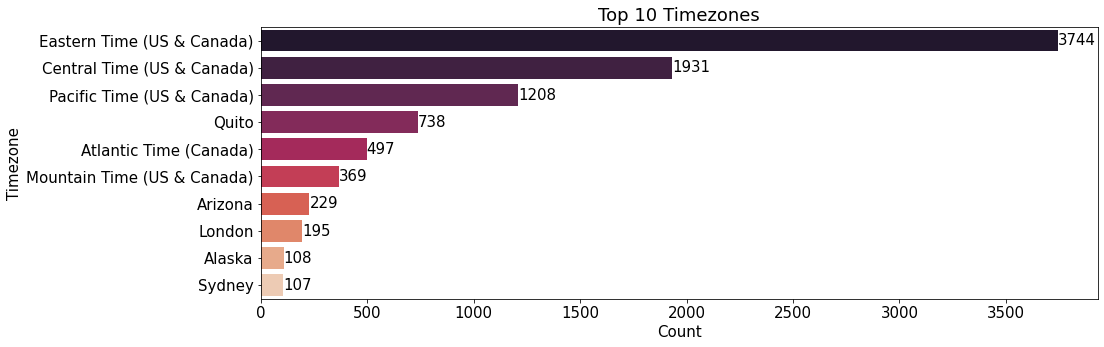

In [70]:
fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.barplot(y = "Timezone", x="Count", data=topTZ, palette="rocket")
plt.title("Top 10 Timezones")

#plt.xticks(rotation=90)

for container in axes.containers:
    axes.bar_label(container)

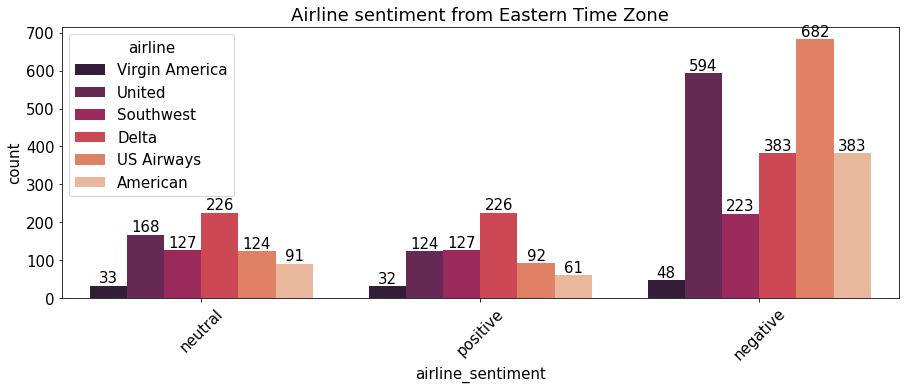

In [71]:
eastTZ = tweets[tweets["user_timezone"] == "Eastern Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=eastTZ, palette="rocket")
plt.title("Airline sentiment from Eastern Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

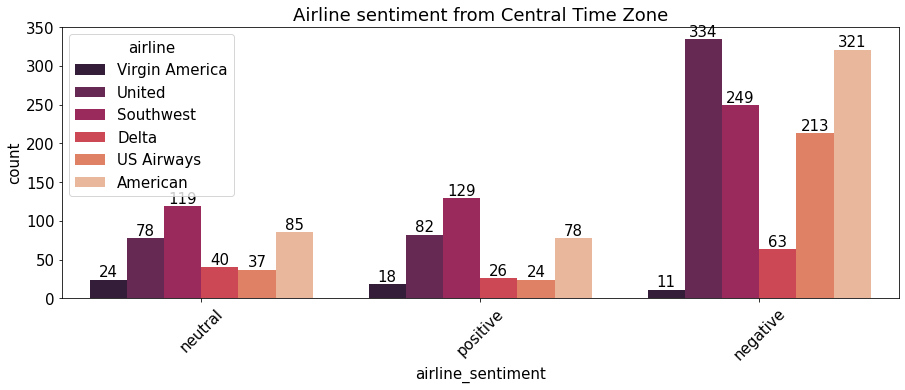

In [72]:
centralTZ = tweets[tweets["user_timezone"] == "Central Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=centralTZ, palette="rocket")
plt.title("Airline sentiment from Central Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

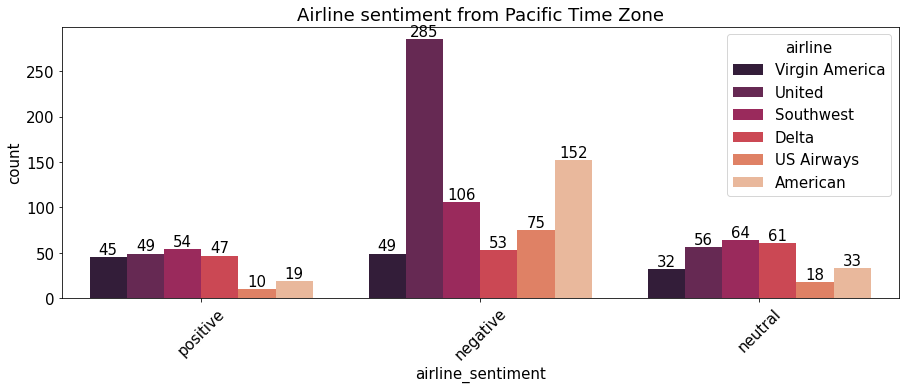

In [73]:
pacificTZ = tweets[tweets["user_timezone"] == "Pacific Time (US & Canada)"]

fig, axes = plt.subplots(figsize=(15, 5))
axes = sns.countplot(x = "airline_sentiment", hue="airline", data=pacificTZ, palette="rocket")
plt.title("Airline sentiment from Pacific Time Zone")

plt.xticks(rotation=45)

for container in axes.containers:
    axes.bar_label(container)

# Conclusion <a class="anchor" id="Conclusion"></a>

Tracking a sentiment analysis is a way that companies can see what their customers think about their company.

Most of the the sentiment are negative.

#### Reasons for negative sentiment

Delta, American, US Airways, and United top complaints are customer service issue and late flight.

Virgin America top complaints are customer service issues and flight booking problems. 

Southwest top complaints are customer service issues and cancelled flights.